#Transitive Win Program

The purpose of this notebook is to create a method for ranking College Football teams in a given year based on how many total teams each individual team should be able to beat based on the Transitive Property. While not perfect, this method can be helpful in comparing teams this sport as it can be difficult as there are 130 teams playing at the highest level and each team only plays about 12/13 games a year.

## Functions



In [ ]:
# Installing and importing necessary functions and modules
get_ipython().system(u' pip install beautifulsoup4')
!pip install lxml
!pip install beautifulsoup4 as bs4
!pip install svglib


from lxml import html
from bs4 import BeautifulSoup
import urllib.request
import numpy as np
import re
import types
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time # for time delays

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


This function pulls data from Wikipedia to determine the teams that are classified into the highest "FBS" level of College Football for a given year.


In [ ]:
def get_Teams(input_year):
    if 1941 <= input_year <= 1945:
        input_year = 1940
    url="https://en.wikipedia.org/wiki/NCAA_Division_I_Football_Bowl_Subdivision_alignment_history"
    # use urllib and BeautifulSoup in order to open and copy the html code of the webpage to another variable
    page = urllib.request.urlopen(url) # opens url
    soup = BeautifulSoup(page, 'lxml') # extracts website HTML code as object soup
    # use soup.find in order to pull out only the html code related to the data wanted
    team_list = soup.findAll('div') # pulls only the written content of the webpage
    A = [] # creates empty list A
    # This loop creates a list of all listed items in written page
    for row in soup.findAll('li'): # row represents each row of code starting between <li> - </li>
        strip = row.text.strip()  # strip represents the actual text of code between <li> - </li>
        A.append(strip) # All text is added as values to list A
    team_list
    first = A.index('Air Force 1957–present') # sets index point for start of list
    last = A.index('Yale 1937–1940, 1946–1981') # sets index point for end of list
    A = A[first:last+1] # limits list to values set between index points
    # Create more empty lists
    B = [] # List set for School name
    C = [] # List set for
    D = [] # List set for
    stop = "1"
    # This for loop determines whether the first year starts with "1" or "2" digit and adds only year component to list B
    for s in A: # runs for loop for each value in A
        index = s.find(" 1") #finds position of first " 1"
        index2 = s.find(" 2") #finds position of first " 2"
        # loop determines if 2 doesn't exist or if 1 exists and occurs before 2
        if index2 == -1 or index < index2 and index != -1:
            B.append(s[:index]) # adds everything from first 1 and on
        else:
            B.append(s[:index2]) # adds everything from first 2 and on

    df = pd.DataFrame(A,columns = ['Team1']) # creates dataframe and sets A to first column called "Team1"
    df['Team'] = B # Creates 2nd column and sets B (School name) as "Team"

    # The following lines replace strings in dataframe that will mess with later formulas
    df.replace("as West Texas State","", inplace=True, regex = True)
    df.replace("as McNeese State","", inplace=True, regex = True)
    df.replace("as Texas–Arlington","", inplace=True, regex = True)
    df.replace("as Colorado State","", inplace=True, regex = True)
    df.replace(" \(\)","", inplace=True, regex = True)
    df.replace("present","2024", inplace=True, regex = True) # update each year
    df.replace("future","2030", inplace=True, regex = True) # update each year
    df.replace("1981","AAAA", inplace = True, regex=True)
    df.replace("81","1981", inplace = True, regex=True)
    df.replace("AAAA","1981", inplace = True, regex=True)
    df.replace("1940","AAAA", inplace = True, regex=True)
    df.replace("40","1940", inplace = True, regex=True)
    df.replace("AAAA","1940", inplace = True, regex=True)
    df.replace("-40","-1981", inplace = True, regex=True)
    df.replace("Southern California","USC", inplace = True, regex=True)

    # The following loop creates a list C that will only contain year data by subtracting the string in list B from A
    for s, s2 in zip(df['Team1'], df['Team']): # creates variables for strings in each set from first 2 columns (A and B with corrections)
        s3 = s.replace(s2,"") # creates string where team names are removed
        C.append(s3.replace(" ","")) # adds leftover string to list C

    # This for loop converts the raw string in C into the list of integer years for D
    for g in C:
        # This loop cuts off any bracketed notes from page
        if "[" in g:
            g = g[0:g.find("[")] # converts g string to all code before '['
        # This loop converts numbers separated by "-" into the range of numbers between them
        while "–" in g:
            index = g.find("–") # sets variable for location of "-"
            r = range(int(g[index-4:index]),int(g[index+1:index+5])+1) #creates range for numbers specified
            # This loop converts the range into strings for each number and adds them into g
            for i in r:
                g = g + "," + str(i)
            # specific steps needed if range begins string of g
            if index == 4:
                g=g[index+6:]
            # for all instances where range does not start string of g
            else:
                g = g[0:index-5]+g[index+5:]
        li = list(g.split(",")) # converts string g into a list separated by ","
        # This loop converts all string in li into int
        for i in range(0, len(li)):
            li[i] = int(li[i])
        D.append(li) # each list added as component of list D
    df['Years'] = D # D added as column in dataframe for years
    df.drop(['Team1'], axis = 1, inplace = True) # drops 1st column from dataframe as all information is redundant
    Team_List = [] # sets blank list for the teams in a given year
    # this loop makes sure that only teams designated make the FBS list
    if input_year >= 1937:
        for team, years in zip(df['Team'], df['Years']): # takes team and years FBS from dataframe
            if input_year in years: # checks if given year found for team
                Team_List.append(team)
    # NCAA records only go back to 1937 for teams so all teams before then will be added to list
    if input_year < 1937:
        Team_List = df['Team'].to_list() # takes all teams from page
    return(Team_List)

This function pulls all the College Football games from sports-reference.com for a given year.

In [ ]:
def get_Games(year):

    url="https://www.sports-reference.com/cfb/years/{}-schedule.html".format(year)
# use urllib and BeautifulSoup in order to open and copy the html code of the webpage to another variable
    page = urllib.request.urlopen(url)
    soup = BeautifulSoup(page, 'lxml')
# use soup.find in order to pull out only the html code related to the data wanted
    game_list = soup.findAll('tr')
    # set empty lists to load data from page
    A = []
    B = []
    C = []
    D = []
    E = []
    F = []
    G = []
    H = []
    I = []
    J = []
    # this loop determines what data to pull from webpage depending on how big the table provided is
    for row in game_list:
        cells = row.findAll('td')
        if len(cells) == 10:
            A.append(cells[0].find(text=True))
            B.append(cells[1].find(text=True))
            C.append(cells[2].find(text=True))
            D.append(cells[3].find(text=True))
            E_find=str(cells[4].find('a'))
            start = E_find.find(">")
            end = E_find.find('<',start)
            if E_find == "None":
                E.append(cells[4].find(text=True))
            else:
                E.append(str(E_find[start+1:end]))
            F.append(cells[5].find(text=True))
            G.append(cells[6].find(text=True))
            H_find=str(cells[7].find('a'))
            start = H_find.find(">")
            end = H_find.find('<',start)
            if H_find == "None":
                H.append(cells[7].find(text=True))
            else:
                H.append(str(H_find[start+1:end]))
            I.append(cells[8].find(text=True))
            J.append(cells[9].find(text=True))
        if len(cells) == 9:
            A.append(cells[0].find(text=True))
            B.append(cells[1].find(text=True))
            D.append(cells[2].find(text=True))
            E_find=str(cells[3].find('a'))
            start = E_find.find(">")
            end = E_find.find('<',start)
            if E_find == "None":
                E.append(cells[3].find(text=True))
            else:
                E.append(str(E_find[start+1:end]))
            F.append(cells[4].find(text=True))
            G.append(cells[5].find(text=True))
            H_find=str(cells[6].find('a'))
            start = H_find.find(">")
            end = H_find.find('<',start)
            if H_find == "None":
                H.append(cells[6].find(text=True))
            else:
                H.append(str(H_find[start+1:end]))
            I.append(cells[7].find(text=True))
            J.append(cells[8].find(text=True))
    df_Games = pd.DataFrame(A,columns = ['Wk'])
    df_Games['Date'] = B
   # df_Games['Time'] = C unneccessary data
    df_Games['Day'] = D
    df_Games['Winner'] = E # name of team to win/tie game
    df_Games['Pts'] = F # points scored by team in 'Winner' spot
    df_Games['@'] = G # designates location of game
    df_Games['Loser'] = H # name of team to lose/tie game
    df_Games['Pts.1'] = I # points scored by team in 'Loser' spot
    #df_Games['Notes'] = J unneccessary data

#df_Games.drop(["Notes","Day","Date","Time","Unnamed: 7","Pts","Pts.1"], axis = 1, inplace = True)
#df_Games = pd.read_csv("2020 Games.csv")
    # clean data by removing unneccessary extra characters
    df_Games["Winner"] = df_Games.Winner.str.replace('(\(\d\))','')   # ('(\(\d\))
    df_Games["Winner"] = df_Games.Winner.str.replace('(\(\d\d\))','')   # ('(\(\d\))
    df_Games["Winner"] = df_Games.Winner.str.replace('\xa0','')   # ('(\(\d\))
    df_Games["Loser"] = df_Games.Loser.str.replace('(\(\d\))','')   # ('(\(\d\))
    df_Games["Loser"] = df_Games.Loser.str.replace('(\(\d\d\))','')   # ('(\(\d\))
    df_Games["Loser"] = df_Games.Loser.str.replace('\xa0','')   # ('(\(\d\))
    # clean data by consolidating naming conventions of teams to how they appear from earlier list
    df_Games.replace('Alabama-Birmingham','UAB', inplace = True)
    df_Games.replace('Southern Mississippi','Southern Miss', inplace = True)
    df_Games.replace('Middle Tennessee State','Middle Tennessee', inplace = True)
    df_Games.replace('Southern Methodist','SMU', inplace = True)
    df_Games.replace('Texas-El Paso','UTEP', inplace = True)
    df_Games.replace('Brigham Young','BYU', inplace = True)
    df_Games.replace('Louisiana-Monroe','Louisiana–Monroe', inplace = True)
    df_Games.replace('Texas-San Antonio','UTSA', inplace = True)
    df_Games.replace('Central Florida','UCF', inplace = True)
    df_Games.replace('Mississippi','Ole Miss', inplace = True)
    df_Games.replace('Texas Christian','TCU', inplace = True)
    df_Games.replace('Florida International','FIU', inplace = True)
    df_Games.replace('Louisiana State','LSU', inplace = True)
    df_Games.replace('Bowling Green State','Bowling Green', inplace = True)
    df_Games.replace('Texas A&amp;M','Texas A&M', inplace = True)
    df_Games.replace('Nevada-Las Vegas','UNLV', inplace = True)
    df_Games.replace('Connecticut','UConn', inplace = True)
    df_Games.replace("Saint Mary's (CA)","Saint Mary's", inplace = True)
    df_Games.replace('Virginia Military Institute','VMI', inplace = True)
    df_Games.replace('William &amp; Mary','William & Mary', inplace = True)
    df_Games.replace('Pennsylvania','Penn', inplace = True)
    df_Games.replace('West Texas A&amp;M','West Texas A&M', inplace = True)
    df_Games.replace('Washington &amp; Lee','Washington & Lee', inplace = True)
    df_Games.replace('Detroit Mercy','Detroit', inplace = True)
    df_Games.replace('Hardin-Simmons','Hardin–Simmons', inplace = True)
    df_Games.replace('New York University','NYU', inplace = True)
    df_Games.replace('Carnegie Mellon','Carnegie Tech', inplace = True)
    df_Games.replace('Texas-Arlington','Texas–Arlington', inplace = True)
    df_Games.replace('Southern','Southern U.', inplace = True)
    df_Games.replace('Grambling State','Grambling', inplace = True)
    df_Games.replace('Centenary (LA)','Centenary', inplace = True)
    df_Games.replace('Trinity (Texas)','Trinity (TX)', inplace = True)
    df_Games.replace('Southern California','USC', inplace = True)
    df_Games.replace('North Carolina State','NC State', inplace = True)


    return (df_Games)

This function pulls the data for the final rankings for a given year.

In [ ]:
def get_Final_AP_Poll(year):
    # depending on the year, a different URL format is required
    if 1936 <= year <= 1955:
        url = "https://en.wikipedia.org/wiki/{}_NCAA_football_rankings".format(year)
    elif 1956 <= year <= 1972:
        url = "https://en.wikipedia.org/wiki/{}_NCAA_University_Division_football_rankings".format(year)
    elif 1973 <= year <= 1977:
        url = "https://en.wikipedia.org/wiki/{}_NCAA_Division_I_football_rankings".format(year)
    elif 1978 <= year <= 2005:
        url = "https://en.wikipedia.org/wiki/{}_NCAA_Division_I-A_football_rankings".format(year)
    elif 2006 <= year <= 2023:
        url = "https://en.wikipedia.org/wiki/{}_NCAA_Division_I_FBS_football_rankings".format(year)
    else:
        print("No AP Poll for this year")
    if year >= 1936:
        page = urllib.request.urlopen(url)
        soup = BeautifulSoup(page, 'lxml')
        table = soup.find('table', class_='wikitable')
        A=[]
        B=[]
        C=[]
        D=[]
        E=[]
        F=[]
        i=0
        #print(table)
        for row in table.findAll('tr'):
            cells = row.findAll('td')
            if len(cells) != 0:
                #print(cells[-1])
                i=i+1
                #A.append(cells[-1].find(text=True))
                B.append(i)
                n = cells[-1]
                strip = n.text.strip()
                A.append(strip)
                #print(n[-10:])
                l = len(cells)
                A_find=str(cells[l-1].find('a'))
                #A.append(A_find)
        A.pop()
        B.pop()
        if year == 1940:
            A.pop()
            B.pop()
        if 2004 <= year <= 2006:
            A.pop()
            A.pop(0)
            B.pop()
            B.pop(0)
            G = []
            for num in B:
                num = num -1
                G.append(num)
            B = G
        B = []
        i = 0
        tie = 0
        for team in A:
            if team:
                i = i+1
                if tie%2 == 1:
                    B.append(i-1)
                else:
                    B.append(i)
                F.append(year)
                p = team.rfind("(")
                text = team[p-1:]
                if team.find('т') != -1:
                    tie = tie + 1
                team = team.replace(text,'')
                team = team.replace('т','')
                text = text.replace('т','')
                check = text.find('–')
                if check == -1:
                    E.append(text)
                    p = team.rfind("(")
                    text = team[p-1:]
                    team = team.replace(text,'')
                    C.append(text)
                    D.append(team)
                else:
                    C.append(text)
                    D.append(team)
                    E.append('')
    if year < 1936:
        B = []
        C = []
        D = []
        E = []
        F = []
    df_Poll = pd.DataFrame(F,columns = ['Year'])
    df_Poll['Rank'] = B
    df_Poll['Team'] = D
    df_Poll['Record'] = C
    df_Poll['1st'] = E
    #df_Poll['year'] = F
    return df_Poll


This function looks through the df_Games dataframe to compile a list of all teams that played.

In [ ]:
def get_Teams2(df_Games):
    Teams2 = []
    for winner, loser in zip(df_Games['Winner'], df_Games['Loser']):
        if winner not in Teams2:
            Teams2.append(winner)
        if loser not in Teams2:
            Teams2.append(loser)
    return(Teams2)

This function cleans the df_Games dataframe to only include FBS vs FBS games.

In [ ]:
def clean_df(df_Games, Teams, Teams2, week):
    Diff = []
    for team in Teams2:
        if team not in Teams:
            Diff.append(team)
    for team in Teams:
        if team not in Teams2:
            Teams.remove(team)
    #print(len(Diff))
    df_Games['Wk'] = df_Games['Wk'].astype(int)
    check = []
    for winner, loser, points in zip(df_Games['Winner'], df_Games['Loser'], df_Games['Wk']):
        if winner in Diff or loser in Diff or points > week:
            check.append('Remove')
        else:
            check.append('Keep')
    df_Games['check'] = check
    #print(df_Games.shape)
    df_Games = df_Games[df_Games['check'] == 'Keep']
#df_Games.drop(["Notes","Day","Date","Time","@","Pts","Pts.1","check"], axis = 1, inplace = True)
#df_Games.drop(['check'], axis = 1, inplace = True)
    #print(df_Games.shape)
    return(df_Games)
#df_Games

The next 3 functions find the teams that a given team has beat, lost to, or tied.

In [ ]:
def get_Wins(team, df_Games):
    Wins = []
    for winner, loser, P1, P2 in zip(df_Games['Winner'], df_Games['Loser'], df_Games['Pts'], df_Games['Pts.1']):
        if winner == team and P1 != P2:
            Wins.append(loser)

    return (Wins)
#for winner, loser in zip(df_Games['Winner'], df_Games['Loser']):
 #   if winner in Teams:
  #      win_dict[winner].append(loser)
#win_dict

In [ ]:
def get_Losses(team, df_Games):
    Losses = []
    for winner, loser, P1, P2 in zip(df_Games['Winner'], df_Games['Loser'], df_Games['Pts'], df_Games['Pts.1']):
        if loser == team and P1 != P2:
            Losses.append(winner)

    return (Losses)

In [ ]:
def get_Ties(team, df_Games):
    Ties = []
    for winner, loser, P1, P2 in zip(df_Games['Winner'], df_Games['Loser'], df_Games['Pts'], df_Games['Pts.1']):
        if loser == team and P1 == P2:
            Ties.append(winner)
        if winner == team and P1 == P2:
            Ties.append(loser)
    return (Ties)

This function lists the teams remaining on a given team's schedule.

In [ ]:
def get_Remaining(team, df_Games, week, FBS):
    Remaining = []
    for winner, loser, w in zip(df_Games['Winner'], df_Games['Loser'], df_Games['Wk']):
        if w > week:
            if winner == team:
                if loser in FBS:
                    Remaining.append(loser)
            if loser == team:
                if winner in FBS:
                    Remaining.append(winner)
    return (Remaining)

The next 2 functions use a teams wins/losses and those teams' wins/losses to find all transitive wins/losses within FBS.

In [ ]:
def get_T_wins(Team,df_Games):
    wins = get_Wins(Team,df_Games) #finds all teams *Team* has beat
    control = []
    I = []
    # this loop runs through all teams in wins list to remove duplicates
    for win in wins:
        if win not in control:
            control.append(win)
    win = control
    T_wins = win
    teams_left = win# this list must not start empty  {}
    i = 1
    l = len(T_wins) # number of unique wins
    I = [1]*l
    while teams_left:
        i=i+1 # iterates i variable
        difference = [] # sets empty list
        for team in teams_left:
            #T_wins.append(team)
            #print(team)
            tlist = get_Wins(team,df_Games)
            for win in tlist:
                if win not in T_wins:
                    T_wins.append(win)
                    difference.append(win)
                    I.append(i)
        teams_left = difference
    if Team in T_wins:
        T_wins.remove(Team)
    return(T_wins)

In [ ]:
def get_T_losses(Team,df_Games):
    losses = get_Losses(Team,df_Games)
    control = []
    I = []
    for loss in losses:
        if loss not in control:
            control.append(loss)
    loss = control
    T_losses = loss
    teams_left = loss# this list must not start empty  {}
    i = 1
    l = len(T_losses)
    I = [1]*l
    while teams_left:
        i=i+1
        difference = []
        for team in teams_left:
            #T_wins.append(team)
            #print(team)
            tlist = get_Losses(team,df_Games)
            for loss in tlist:
                if loss not in T_losses:
                    T_losses.append(loss)
                    difference.append(loss)
                    I.append(i)
        teams_left = difference
    if Team in T_losses:
        T_losses.remove(Team)
    return(T_losses)

This function determines if a team falls within a "cluster" defined in this program as a team with a transitive win over itself. Since in sports it is possible for an outcome such as: A>B B>C C>A, it is necessary to determine other factors to compare teams A, B, and C.

In [ ]:
def get_Cluster(Team,df_Games):
    wins = get_Wins(Team,df_Games)
    control = []
    I = []
    for win in wins:
        if win not in control:
            control.append(win)
    win = control
    T_wins = wins
    teams_left = wins# this list must not start empty  {}
    i = 1
    l = len(T_wins)
    I = [1]*l
    while teams_left:
        i=i+1
        difference = []
        for team in teams_left:
            #T_wins.append(team)
            #print(team)
            tlist = get_Wins(team,df_Games)
            for win in tlist:
                if win not in T_wins:
                    T_wins.append(win)
                    difference.append(win)
                    I.append(i)
        teams_left = difference
    if Team in T_wins:
        Cluster = True
    else:
        Cluster = False
    return(Cluster)

In [ ]:
def get_df_T_Wins(Teams, df_Games):
    T_wins = []
    l = []
    m = []
    n = []
    p = []
    for team in Teams:
        t = (get_T_wins(team, df_Games))
        T_wins.append(t)
        l.append(len(t))

    df_T_wins = pd.DataFrame(Teams,columns = ['Team'])
    df_T_wins['#'] = l
    df_T_wins['Transitive Wins'] = T_wins
    for wins, T in zip(T_wins, df_T_wins['Team']):
        n=[]
        for team in Teams:
            if team not in wins and team != T:
                n.append(team)
        m.append(n)
        p.append(len(n))
    df_T_wins['Missing'] = m
    #df_T_wins['#2'] = p
    #df_T_wins['check'] = df_T_wins['#'] +df_T_wins['#2']

    df_T_wins.sort_values(by= '#', ascending = False, inplace = True)
    return(df_T_wins)

In [ ]:
def get_Record(Team, df_Games):
    win = 0
    tie = 0
    loss = 0
    Record = []
    for winner, loser, pwin, ploss in zip(df_Games['Winner'],df_Games['Loser'],df_Games['Pts'],df_Games['Pts.1']):
        if Team == winner: # checks if team in Winner group
            if pwin != ploss: # checks if win
                win = win+1
            if pwin == ploss and pwin != "None": # checks if tie
                tie = tie+1
        if Team == loser: # checks if team in Loser group
            if pwin != ploss: # checks if win
                loss = loss+1
            if pwin == ploss and pwin != "None": # checks if tie
                tie = tie+1
    # different record structure needed in instance of ties
    if tie == 0:
        record = "({}–{})".format(win,loss)
    if tie != 0:
        record = "({}–{}–{})".format(win,loss,tie)

    return(record)


In [ ]:
def get_Transitive_Wins(year):
    week = 30
    Teams = get_Teams(year)
    df_Games = get_Games(year)
    df_Games_All = df_Games.copy()
    Teams2 = get_Teams2(df_Games)
    Teams = [x for x in Teams2 if x not in Teams]
    Teams_Remove = Teams.copy()
    for team in Teams:
        if team not in Teams2:
            Teams_Remove.append(team)
    Teams = [x for x in Teams2 if x not in Teams_Remove]
    df_Games = clean_df(df_Games, Teams, Teams2, week)
    #Wins = get_Wins(team, df_Games)
    df_T_Wins = get_df_T_Wins(Teams, df_Games)
    Poll = get_Final_AP_Poll(year)
    A = []
    B = []
    C = []
    D = []
    #print(df_T_Wins['Team'])
    #print(Poll['Team'])
    list1 = df_T_Wins['Team'].tolist()
    list2 = Poll['Team'].tolist()
    for team in list1:
        if team in list2:
            ind = list2.index(team)
            A.append(Poll['Rank'][ind])
            #B.append(Poll['Record'][ind])
            C.append(Poll['1st'][ind])
        else:
            A.append('NR')
            #B.append('')
            C.append('')
        record = get_Record(team,df_Games)
        record_All = get_Record(team,df_Games_All)
        B.append(record)
        D.append(record_All)
    df_T_Wins['Rank'] = A
    df_T_Wins['FBS Record'] = B
    df_T_Wins['Full Record'] = D
    df_T_Wins['1st'] = C

    return(df_T_Wins)

In [ ]:
def get_Team_info(Team, year):
    week = 30
    Teams = get_Teams(year)
    df_Games = get_Games(year)
    Teams2 = get_Teams2(df_Games)
    df_Games = clean_df(df_Games, Teams, Teams2, week)
    Wins = get_Wins(Team, df_Games)
    T_Wins = get_T_wins(Team, df_Games)
    Record = get_Record(Team, df_Games)
    print("Team: ", Team, year)
    print("Record: ", Record)
    print("Wins (",len(Wins),"):", Wins)
    print("Transitive Wins (",len(T_Wins),"/",len(Teams)-1,"):", T_Wins)
    Missing = []
    for team in Teams:
        if team not in T_Wins and team != Team:
            Missing.append(team)
    print("Missing:",Missing)


In [ ]:
def get_Differential_Tier(df_Games, Team, Best_Win):
    score = 0
    for winner, loser, P1, P2 in zip(df_Games['Winner'], df_Games['Loser'], df_Games['Pts'], df_Games['Pts.1']):
        if winner == Team:
            num = Tier_dict.get(loser)
            if num == Best_Win:
                score = score + (int(P1) - int(P2))
        if loser == Team:
            num = Tier_dict.get(winner)
            if num == Best_Win:
                score = score - (int(P1) - int(P2))
    return(score)





In [ ]:
def get_Differential(df_Games, Team):
    Points_Scored = 0
    Points_Allowed = 0
    for winner, loser, P1, P2 in zip(df_Games['Winner'], df_Games['Loser'], df_Games['Pts'], df_Games['Pts.1']):
        if P1:
            if winner == Team:
                #score = score + (int(P1) - int(P2))
                Points_Scored = Points_Scored + int(P1)
                Points_Allowed = Points_Allowed + int(P2)
            if loser == Team:
                #score = score - (int(P1) - int(P2))
                Points_Scored = Points_Scored + int(P2)
                Points_Allowed = Points_Allowed + int(P1)
    Differential = Points_Scored - Points_Allowed
    return(Differential, Points_Scored, Points_Allowed)

In [ ]:
def Rankings_Compare(List1, List2):
    Placement = list(range(1,26))
    dict1 = {List1[i] : Placement[i] for i in range(len(List1))}
    dict2 = {List2[i] : Placement[i] for i in range(len(List2))}
    d = 0
    for team in List1:
        a = dict1.get(team)
        b = dict2.get(team,26)
        nd = b - a
        d = d + abs(nd)
  #      print(team)
  #      print(nd)
    for team in List2:
        if team not in List1:
            a = dict2.get(team)
            b = dict1.get(team,26)
            nd = a - b
            d = d + abs(nd)
  #          print(team)
  #          print(nd)
    ad = d/25
    return(d, ad)

In [ ]:
def get_Team_scores(Team, FBS, df_Games):

    i = 1
    Wins2 = 0
    new_list = []
    I_new = []
    team_list = get_Wins(Team,df_Games)
    Wins_List = team_list

    for team in team_list:
        if team in FBS:
            new_list.append(team)
    team_list = new_list

    for team in team_list:
        num = get_Wins(team, df_Games)
        Wins2 = Wins2 + len(num)
    Wins = len(team_list)
    new_list = []
    length = len(team_list)
    I = [1] * length
    diff = team_list
    while length != 0:
        i = i + 1
        for team in diff:
            tlist = get_Wins(team,df_Games)
            for team2 in tlist:
                if team2 not in team_list:
                    if team2 not in new_list:
                        if team2 in FBS:
                            if team2 != Team:
                                new_list.append(team2)
                                I_new.append(i)
        length = len(new_list)
        diff = new_list
        team_list = team_list + new_list
        I = I + I_new
        new_list = []
        I_new = []
    T_Wins = len(team_list)
    score = 0
    for point in I:
        score = score + (.5 ** (point - 1))

    return(Wins_List, Wins, Wins2, I, T_Wins, score)

In [ ]:
def get_FCS(df_Games, Team, FBS):
    FCS_Wins = []
    FCS_Losses = []
    for winner, loser in zip(df_Games['Winner'], df_Games['Loser']):
        if winner == Team and loser not in FBS:
            FCS_Wins.append(loser)
        if loser == Team and winner not in FBS:
            FCS_Losses.append(winner)
    return(FCS_Wins, FCS_Losses)

In [ ]:
def get_FBS(df_Games, Teams, Teams2):
    Teams_List = []
    for team in Teams:
        if team in Teams2:
            Teams_List.append(team)
    #Diff = []
    #for team in Teams2:
    #    if team not in Teams:
    #        Diff.append(team)
    #for team in Teams:
    #    if team not in Teams2:
    #        Teams.remove(team)
    return(Teams_List)

In [ ]:
def get_Tiers(T_Wins):
    T_Wins_Unique = []
    Tier_List = []
    for t in T_Wins:
        if t not in T_Wins_Unique:
            T_Wins_Unique.append(t)
    T_Wins_Unique.sort(reverse = True)

    l = len(T_Wins_Unique)
    Tiers = list(range(1,l+1))

    for num in T_Wins:
        for num1, num2 in zip(T_Wins_Unique, Tiers):
            if num == num1:
                Tier_List.append(num2)
    return(Tier_List)


In [ ]:
def get_Ranking(Lists):
    List_Sorted = (Lists[:])
    List_Sorted = list(map(float, List_Sorted))
    List_Sorted.sort(reverse = True)
    Ranking = []
    i = 1
    R = 1
    item = List_Sorted[0]
    Ranks = [R]
    items = [item]
    for L in List_Sorted:
        if L != item:
            R = i
            item = L
            Ranks.append(R)
            items.append(item)
        i = i + 1

    Rank_dict = {items[i] : Ranks[i] for i in range(len(items))}
    for L in Lists:
        A = Rank_dict[float(L)]
        Ranking.append(A)
    return(Ranking)

In [ ]:
def get_Tier_data(df_Games, df_Games_All, Team, Tier_dict):
    Tier_Wins = []
    Tier_Losses = []
    Best_Wins = []
    Worst_Losses = []
    Win_Counts = []
    Loss_Counts = []
    Tier_Values = list(Tier_dict.values())
    FCS = max(Tier_Values)# + 1
    for team in Team:
        Tier_Win = []
        Tier_Loss = []
        FCS_Win, FCS_Loss = get_FCS(df_Games_All, team, Team)
        if FCS_Win:
            Tier_Win.append(FCS)
            Tier_Win * len(FCS_Win)
        if FCS_Loss:
            Tier_Loss.append(FCS)
            Tier_Loss * len(FCS_Loss)
        Best_Win = 99
        Worst_Loss = -1
        Win_Count = 0
        Loss_Count = 0
        win_list = get_Wins(team, df_Games)
        loss_list = get_Losses(team, df_Games)
        if win_list or FCS_Win:
            for team in win_list:
                num = Tier_dict.get(team)
                Tier_Win.append(num)
            Best_Win = min(Tier_Win)
            Win_Count = Tier_Win.count(Best_Win)
        Tier_Wins.append(Tier_Win)
        Best_Wins.append(Best_Win)
        Win_Counts.append(Win_Count)

        if loss_list or FCS_Loss:
            for team in loss_list:
                num = Tier_dict.get(team)
                Tier_Loss.append(num)
            Worst_Loss = max(Tier_Loss)
            Loss_Count = Tier_Loss.count(Worst_Loss)
        Tier_Losses.append(Tier_Loss)
        Worst_Losses.append(Worst_Loss)
        Loss_Counts.append(Loss_Count)

    return(Best_Wins, Win_Counts, Worst_Losses, Loss_Counts)

In [ ]:
def get_Conference(team):
    if team in ['Boston College','Clemson','Duke','Florida State','Georgia Tech','Louisville','Miami (FL)','North Carolina','NC State','Pittsburgh','Syracuse','Virginia','Virginia Tech','Wake Forest' ]:
        conference = 'ACC'
        color = 'red'
    if team in ['Cincinnati','East Carolina','Houston','Memphis','Navy','SMU','South Florida','Temple','Tulane','Tulsa','UCF']:
        conference = 'American'
        color = 'orange'
    if team in ['Illinois','Indiana','Iowa','Maryland','Michigan','Michigan State','Minnesota','Nebraska','Northwestern','Ohio State','Penn State','Purdue','Rutgers','Wisconsin']:
        conference = 'Big Ten'
        color = 'goldenrod'
    if team in ['Baylor','Iowa State','Kansas','Kansas State','Oklahoma','Oklahoma State','TCU','Texas','Texas Tech','West Virginia']:
        conference = 'Big 12'
        color = 'pink'
    if team in ['Charlotte','FIU','Florida Atlantic','Louisiana Tech','Middle Tennessee','North Texas','Rice','UAB','UTEP','UTSA','Western Kentucky','Sam Houston','Jacksonville State']:
        conference = 'Conference USA'
        color = 'darkgreen'
    if team in ['Army','BYU','Liberty','New Mexico State','Notre Dame','UConn','Massachusetts']:
        conference = 'Independent'
        color = 'grey'
    if team in ['Akron','Ball State','Bowling Green','Buffalo','Central Michigan','Eastern Michigan','Kent State','Miami (OH)','Northern Illinois','Ohio','Toledo','Western Michigan']:
        conference = 'MAC'
        color = 'cyan'
    if team in ['Air Force','Boise State','Colorado State','Fresno State','Hawaii','Nevada','New Mexico','San Diego State','San Jose State','UNLV','Utah State','Wyoming']:
        conference = 'Mountain West'
        color = 'darkblue'
    if team in ['Arizona','Arizona State','California','Colorado','Oregon','Oregon State','Stanford','UCLA','USC','Utah','Washington','Washington State']:
        conference = 'Pac 12'
        color = 'purple'
    if team in ['Alabama','Arkansas','Auburn','Florida','Georgia','Kentucky','LSU','Mississippi State','Missouri','Ole Miss','South Carolina','Tennessee','Texas A&M','Vanderbilt']:
        conference = 'SEC'
        color = 'black'
    if team in ['Appalachian State','Arkansas State','Coastal Carolina','Georgia Southern','Georgia State','James Madison','Louisiana','Louisiana–Monroe','Marshall','Old Dominion','South Alabama','Southern Miss','Texas State','Troy']:
        conference = 'Sun Belt'
        color = 'brown'
    return(conference,color)

This function is soley for the purpose of seeing how the data would change if results of the games had been different

In [ ]:
def get_Alternate_Games(df_Games,new_winner,new_loser):
    Winners = []
    Losers = []
    for winner, loser in zip(df_Games['Winner'], df_Games['Loser']):
        if winner == new_loser and loser == new_winner:
            Winners.append(new_winner)
            Losers.append(new_loser)
        else:
            Winners.append(winner)
            Losers.append(loser)
    df_Games['Winner'] = Winners
    df_Games['Loser'] = Losers
    return (df_Games)

This function is for manually fixing data that may have been added to the data source incorrectly

In [ ]:
def fix_Data(df_Games,team1,team2,score1,score2):
    Winners = []
    Losers = []
    Winner_Score = []
    Loser_Score = []
    if score1 > score2:
        winner1 = team1
        loser1 = team2
        winner_score = score1
        loser_score = score2
    elif score2 > score1:
        winner1 = team2
        loser1 = team1
        winner_score = score2
        loser_score = score1
    for winner2, loser2, points1, points2 in zip(df_Games['Winner'], df_Games['Loser'], df_Games['Pts'], df_Games['Pts.1']):
        if winner1 == winner2 and loser1 == loser2:
            Winners.append(winner1)
            Losers.append(loser1)
            Winner_Score.append(winner_score)
            Loser_Score.append(loser_score)
        else:
            Winners.append(winner2)
            Losers.append(loser2)
            Winner_Score.append(points1)
            Loser_Score.append(points2)
    return(df_Games)


This funciton is to remove games from the dataset for reasons such as duplicate entries in source

In [ ]:
def remove_Game(df_Games,team1,team2):
    check = []
    for winner, loser in zip(df_Games['Winner'], df_Games['Loser']):
        if team1 == winner and team2 == loser:
            check.append('Remove')
        elif team2 == winner and team1 == loser:
            check.append('Remove')
        else:
            check.append('Keep')
    l = len(check)
    df_Games['check'] = check
    df_Games = df_Games[df_Games['check'] == 'Keep']
    return (df_Games)


Tis function is for the case of adding games in cases such as the data source has not yet been updated

In [ ]:
def add_Game(df_Games,team1,team2,week):
    newrow = (week,'','',team1,'','',team2,'','')
    df_Games.loc[len(df_Games)] = newrow
    return(df_Games)


## Historical Data

In [ ]:
column_names = ["Year","Team", "#", "Transitive Wins","Missing"]
df_Champions = pd.DataFrame(columns = column_names)
years_remove = [1871,1967,1989,2003,2007,2014,2015,2016]
df_dict = {}

for year in range(1869,2021):
    if year not in years_remove:
        clear_output(wait=True)
        print(year)
        week = 30
        df_T_Wins = get_Transitive_Wins(year)
        time.sleep(3)
        df_T_Wins['Year'] = year
        exec('df_T_Wins_{} = df_T_Wins'.format(year))
        maxa = df_T_Wins.iloc[0,1]
        i = 0
        for num in df_T_Wins['#']:
            if num == maxa:
                i = i+1
        new_df = df_T_Wins.iloc[0:i,:]
        df_Champions = df_Champions.append(new_df, ignore_index = True)
pd.set_option("display.max_rows", None, "display.max_columns", None)
df_Champions

1869


<ipython-input-3-462c299f0848>:49: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  A.append(cells[0].find(text=True))
<ipython-input-3-462c299f0848>:50: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  B.append(cells[1].find(text=True))
<ipython-input-3-462c299f0848>:51: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  D.append(cells[2].find(text=True))
<ipython-input-3-462c299f0848>:59: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  F.append(cells[4].find(text=True))
<ipython-input-3-462c299f0848>:60: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  G.append(cells[5].find(text=True))
<ipython-input-3-462c299f0848>:68: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  I.a

No AP Poll for this year


NameError: ignored

In [ ]:
Champs = df_Champions['Team']
Champs.value_counts()

In [ ]:
column_names = ["Year","Team", "#", "Transitive Wins","Missing","#2","check"]
#df_1937 = get_Transitive_Wins(1937)
df_non_Champions = pd.DataFrame(columns = column_names)
#df_Champions = df_1937.iloc[0:1,:]
#years = range(1937,2021)
years = [1967,1989,2003,2007,2014,2015,2016]

for year in years:
    clear_output(wait=True)
    print(year)
    week = 30
    df_T_Wins = get_Transitive_Wins(year)
    df_T_Wins['Year'] = year
    exec('df_T_Wins_{} = df_T_Wins'.format(year))
    max = df_T_Wins.iloc[0,1]
    i = 0
    for num in df_T_Wins['#']:
        if num != max:
            i = i+1
    new_df = df_T_Wins.tail(i)
    df_non_Champions = df_non_Champions.append(new_df, ignore_index = True)
df_non_Champions


In [ ]:
column_names = ["Year","Rank", "Team", "Record","1st"]
df_AP_Champions = pd.DataFrame(columns = column_names)
for year in range(1936,2021):
    df_Final_AP_Poll = get_Final_AP_Poll(year)
    new_df = df_Final_AP_Poll.iloc[0:i,:]
    df_AP_Champions = df_AP_Champions.append(new_df, ignore_index = True)
    print(df_Final_AP_Poll)
    print('--------------------------------------------------')


In [ ]:
df_AP_Champions

In [ ]:
AP_Champs = df_AP_Champions['Team']
AP_Champs.value_counts()

In [ ]:
df_AP_T_Champs = df_Champions[df_Champions['Year'] >= 1936]
AP_T_Champs = df_AP_T_Champs['Team']
AP_T_Champs.value_counts()


## To Google Sheets

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials
from gspread_dataframe import set_with_dataframe

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
from gspread_dataframe import set_with_dataframe
sh = gc.create('FBS Transitive Data')

worksheet = gc.open('FBS Transitive Data').sheet1
set_with_dataframe(worksheet, df_Champions)

worksheet2 = sh.add_worksheet(title="1869", rows="150", cols="10")
worksheet3 = sh.add_worksheet(title="1870", rows="150", cols="10")
for num in range(4,153):
    year = num + 1868
    exec('worksheet{} = sh.add_worksheet(title="{}", rows="150", cols="10")'.format(num,year))

In [ ]:
set_with_dataframe(worksheet2, df_T_Wins_1869)
set_with_dataframe(worksheet3, df_T_Wins_1870)
for num in range(4,153):
    year = num + 1868
    exec('set_with_dataframe(worksheet{}, df_T_Wins_{})'.format(num,year))



### Weekly Data

In [ ]:
from gspread_dataframe import set_with_dataframe
sh = gc.create('FBS Transitive Data 2023')

worksheet = gc.open('FBS Transitive Data 2023').sheet1
set_with_dataframe(worksheet, df_team_scores)

In [ ]:
from gspread_dataframe import set_with_dataframe
week = 'Final'
worksheet = gc.open('FBS Transitive Data 2023')

title1 = ("Week {} Rankings").format(week)
title2 = ("Week {} Rankings Raw Data").format(week)

worksheet2 = worksheet.add_worksheet(title=title1, rows="133", cols="8")
set_with_dataframe(worksheet2, df_team_scores)

worksheet2 = worksheet.add_worksheet(title=title2, rows="133", cols="8")
set_with_dataframe(worksheet2, df_team_scores_raw)

#worksheet2 = worksheet.add_worksheet(title="Week 3", rows="131", cols="14")
#set_with_dataframe(worksheet2, df_team_scores)
#worksheet2 = worksheet.add_worksheet(title="Week 4", rows="131", cols="12")
#set_with_dataframe(worksheet2, df_team_scores)
#worksheet2 = worksheet.add_worksheet(title="Week 5", rows="131", cols="12")
#set_with_dataframe(worksheet2, df_team_scores)
#worksheet2 = worksheet.add_worksheet(title="Week 6", rows="131", cols="14")
#set_with_dataframe(worksheet2, df_team_scores)
#worksheet2 = worksheet.add_worksheet(title="Week 7", rows="131", cols="14")
#set_with_dataframe(worksheet2, df_team_scores)

## Search

In [ ]:
get_Teams(2020)

In [ ]:
get_Team_info("Michigan", 2021)

In [ ]:
df = get_Transitive_Wins(2020)
df

In [ ]:
#for year in range(1941,2021):
df_Final_AP_Poll = get_Final_AP_Poll(1937)
#print(year)
df_Final_AP_Poll

df_Final_AP_Poll['Record'][5]

In [ ]:
get_Games(2020)

In [ ]:
get_Team_info("Notre Dame", 2018)

In [ ]:
df_Games_2020 = get_Games(2020)
FBS_2020 = get_Teams(2020)
FBS = FBS_2020

In [ ]:
get_Team_info("Florida Atlantic", 2020)

##Transitive Dataframe

In [ ]:
year = 2023
week = 30

Team = [] # School
Wins_Count = [] # Number of Wins
Losses_Count = [] # Number of Losses
Ties_Count = [] # Number of Ties
T_Wins_Count = [] # Number of Transitive Wins
T_Losses_Count = [] # Number of Transitive Losses
Best_Wins_Tier = [] # Tier of Team's best win
Worst_Losses_Tier = [] # Tier of Team's worst loss
#WL_Tiers = []
#Best_Wins_Count = []
#Worst_Losses_Count = []
#Win_Diff = []
#Loss_Diff = []
Total_Diff = []
Points_Scored = []
Points_Allowed = []
#Cluster_Differential = []
T_Wins_List = []
T_Losses_List = []
Clusters = []
#Cluster_Win_Percentage = []
#Cluster_Adjusted_Win_Percentage = []
#Total_Adjusted_Win_Percentage = []

Transitive_Score = []
Transitive_Score_2 = []
SOR = []
SOS = []
ROS = []
AROS = []
ROSP = []
AROSP = []
ROS_Remaining = []
ROSRP = []
Team_Record = []

df_Games_All = get_Games(year)
#df_Games_All = get_Alternate_Games(df_Games,"Notre Dame","Marshall")
df_Games_All = remove_Game(df_Games_All,'San Jose State','New Mexico State')
df_Games_All = remove_Game(df_Games_All,'Akron','Buffalo')
df_Games_All = remove_Game(df_Games_All,'Coastal Carolina', 'Virginia')
#df_Games_All = add_Game(df_Games_All,'TCU','Kansas State',15)
#df_Games_All = add_Game(df_Games_All,'Utah','USC',15)
#df_Games_All = add_Game(df_Games_All,'UCF','Tulane',15)



Teams = get_Teams(year)
Teams2 = get_Teams2(df_Games_All)
df_Games_All['Wk'] = df_Games_All['Wk'].astype(int)
df_Games_All_Played = df_Games_All[df_Games_All['Wk'] <= week]
if year > 1936:
    df_Games = clean_df(df_Games_All, Teams, Teams2, week)
else:
    df_Games = df_Games_All
if year == 2020:
    remove = ["UConn", "Old Dominion", "New Mexico State"]
    FBS = [ele for ele in FBS if ele not in remove]
FBS = get_Teams(year)

for team in FBS:
    Wins = get_Wins(team, df_Games)
    Losses = get_Losses(team, df_Games)
    Ties = get_Ties(team, df_Games)
    T_Wins = get_T_wins(team,df_Games)
    T_Losses = get_T_losses(team,df_Games)
    Cluster = get_Cluster(team, df_Games)
    Team.append(team)
    Wins_Count.append(len(Wins))
    Losses_Count.append(len(Losses))
    Ties_Count.append(len(Ties))
    T_Wins_Count.append(len(T_Wins))
    T_Losses_Count.append(len(T_Losses))
    Transitive_Score.append((len(T_Wins))-((len(T_Losses))))
    T_Wins_List.append(T_Wins)
    Clusters.append(Cluster)
    T_Losses_List.append(T_Losses)
Win_dict = {Team[i] : Wins_Count[i] for i in range(len(Team))}
Loss_dict = {Team[i] : Losses_Count[i] for i in range(len(Team))}
trans_win_dict = {Team[i] : T_Wins_Count[i] for i in range(len(Team))}
trans_loss_dict = {Team[i] : T_Losses_Count[i] for i in range(len(Team))}

Tiers = get_Tiers(Transitive_Score)
Tier_dict = {Team[i] : Tiers[i] for i in range(len(Team))}

T_Win_dict = {Team[i] : T_Wins_Count[i] for i in range(len(Team))}
T_Loss_dict = {Team[i] : T_Losses_Count[i] for i in range(len(Team))}

Best_Wins_Tier, Best_Wins, Worst_Losses_Tier, Worst_Losses =  get_Tier_data(df_Games, df_Games_All_Played, FBS, Tier_dict)
for team, C, BW, WL, BWT, WLT in zip(Team, Clusters, Best_Wins, Worst_Losses, Best_Wins_Tier, Worst_Losses_Tier):
    #Differential1 = get_Differential_Tier(df_Games, team, BWT)
    #Differential2 = get_Differential_Tier(df_Games, team, WLT)
    (Differential, PS, PA) = get_Differential(df_Games, team)
    #Win_Diff.append(Differential1)
    #Loss_Diff.append(Differential2)
    Total_Diff.append(Differential)
    Points_Scored.append(PS)
    Points_Allowed.append(PA)
    #WL_Tiers.append(str(BWT)+"/"+str(WLT))
    if C == True:
        CWP = BW/(BW+WL)
        CAWP = (BW +1 )/(BW + WL +2)
        CDiff = Differential
    if C == False:
        CWP = 999
        CAWP = 999
        CDiff = 999

    #Cluster_Adjusted_Win_Percentage.append(CAWP)
    #Cluster_Differential.append(CDiff)

    Wins_list = get_Wins(team, df_Games)
    Losses_list = get_Losses(team, df_Games)
    Ties_list = get_Ties(team, df_Games)
    Wins = len(Wins_list)
    Losses = len(Losses_list)
    Ties = len(Ties_list)
    WP = 0
    if (Wins+Losses) > 0:
       WP = (Wins)/(Wins + Losses)
    AWP = (Wins + 1)/(Wins + Losses + 2)
    #Total_Adjusted_Win_Percentage.append(AWP)
    if Ties:
        R = str(Wins)+'-'+str(Losses)+'-'+str(Ties)
    else:
        R = str(Wins)+'-'+str(Losses)
    Team_Record.append(R)

    T2 = 0
    T3 = 0
    W = 0
    L = 0
    W2 = 0
    L2 = 0
    W3 = 0
    L3 = 0
    for t in Wins_list:
        T2 = T2 + T_Win_dict[t]
        T3 = T3 + Win_dict[t]
        W = W + Win_dict[t]
        L = L + Loss_dict[t]
        W2 = W2 + Win_dict[t]
        L2 = L2 + Loss_dict[t] -1


    for t in Losses_list:
        T2 = T2 - T_Loss_dict[t]
        T3 = T3 - Loss_dict[t]
        W = W + Win_dict[t]
        L = L + Loss_dict[t]
        W2 = W2 + Win_dict[t] -1
        L2 = L2 + Loss_dict[t]

    Transitive_Score_2.append(T2)
    SOR.append(T3)
    SOS.append(W)
    R = str(W)+'-'+str(L)
    RP = '0'
    A = '0'
    AP = '0'
    if W+L > 0 and W2+L2 > 0:
        RP = str(round((W/(W+L)),3))
        A = str(W2)+'-'+str(L2)
        AP = str(round((W2/(W2+L2)),3))
    ROS.append(R)
    ROSP.append(RP)
    AROS.append(A)
    AROSP.append(AP)

    R2 = None
    Remain = get_Remaining(team, df_Games_All, week, FBS)
    for t in Remain:
        W3 = W3 + Win_dict[t]
        L3 = L3 + Loss_dict[t]
    if Remain and W3+L3 != 0:
        R2 = str(W3)+'-'+str(L3)
        RP2 = str(round((W3/(W3+L3)),3))
    else:
        R2 = 0
        RP2 = 0
    ROS_Remaining.append(R2)
    ROSRP.append(RP2)
Team_num = len(FBS)
Rank = list(range(1,Team_num + 1))
SOR_Rank = get_Ranking(SOR)
Total_Diff_Rank = get_Ranking(Total_Diff)
ROSP_Rank = get_Ranking(ROSP)
AROSP_Rank = get_Ranking(AROSP)
ROSRP_Rank = get_Ranking(ROSRP)
NROSPR = []
NROSR = []

for RRP, RR in zip(ROSRP, ROS_Remaining):
    if RR == 0:
        NROSPR.append(None)
        NROSR.append(None)
    else:
        NROSPR.append(RRP)
        NROSR.append(RR)
ROSRP = NROSPR
ROS_Remaining = NROSR

df_team_scores_raw = pd.DataFrame(Rank,columns = ['Rank'])
df_team_scores_raw['Team'] = Team
df_team_scores_raw['Record'] = Team_Record

#df_team_scores['Team (FBS Record)'] = Team_Record
df_team_scores_raw['Tier'] = Tiers
df_team_scores_raw['Transitivity Score'] = Transitive_Score
#df_team_scores['Transitive Wins'] = T_Wins_Count
#df_team_scores['Transitive Losses'] = T_Losses_Count
df_team_scores_raw['Best Win Tier'] = Best_Wins_Tier
df_team_scores_raw['Worst Loss Tier'] = Worst_Losses_Tier
Combined = []
for w,l in zip(Best_Wins_Tier,Worst_Losses_Tier):
    Combined.append(w+l)
df_team_scores_raw['Combined Tier'] = Combined
#df_team_scores_raw['Best Win/Worst Loss Tier'] = WL_Tiers
#df_team_scores['Tier Wins'] = Best_Wins
#df_team_scores['Tier Losses'] = Worst_Losses
#df_team_scores['Best Win Tier Point Differential'] = Win_Diff
#df_team_scores['Worst Loss Tier Point Differential'] = Loss_Diff
#df_team_scores['Cluster Adjusted Win Percentage'] = Cluster_Adjusted_Win_Percentage
#df_team_scores['Record'] = Record
#df_team_scores['Record of Schedule'] = ROS
df_team_scores_raw['Strength of Record'] = SOR
df_team_scores_raw['Strength of Record Rank'] = SOR_Rank

df_team_scores_raw['Points Scored'] = Points_Scored
df_team_scores_raw['Points Allowed'] = Points_Allowed
df_team_scores_raw['Total Point Differential'] = Total_Diff
df_team_scores_raw['Total Point Differential Rank'] = Total_Diff_Rank

df_team_scores_raw['Record of Schedule'] = ROS
df_team_scores_raw['Record of Schedule %'] = ROSP
df_team_scores_raw['Record of Schedule Rank'] = ROSP_Rank

df_team_scores_raw['Adjusted Record of Schedule'] = AROS
df_team_scores_raw['Adjusted Record of Schedule %'] = AROSP
df_team_scores_raw['Adjusted Record of Schedule Rank'] = AROSP_Rank

df_team_scores_raw['Record of Schedule Remaining'] = ROS_Remaining
df_team_scores_raw['Record of Schedule Remaining %'] = ROSRP
df_team_scores_raw['Record of Schedule Remaining Rank'] = ROSRP_Rank

#df_team_scores['Total Adjusted Win Percentage'] = Total_Adjusted_Win_Percentage
#df_team_scores['Transitivity Record Score'] = SOR
#df_team_scores['Strength of Schedule'] = SOS

#df_team_scores['Cluster Point Differential'] = Cluster_Differential
df_team_scores_raw['Transitive Wins'] = T_Wins_Count
df_team_scores_raw['Transitive Losses'] = T_Losses_Count

df_team_scores_raw['Transitive Wins List'] = T_Wins_List
df_team_scores_raw['Transitive Losses List'] = T_Losses_List

df_team_scores_raw['Cluster'] = Clusters

#df_team_scores['Wins List'] = team_list
#df_team_scores['T Wins List'] = T_Wins_List
#df_team_scores['Best Win'] = Best_Wins
#df_team_scores['Number of Wins'] = Count_List
#df_team_scores['Differential'] = Diff

pd.set_option("display.max_rows", None, "display.max_columns", None)
#df_team_scores.sort_values(by= ['Transitivity Score', 'Best Win Tier', 'Worst Loss Tier', 'Cluster Adjusted Win Percentage', 'Cluster Point Differential', 'Total Adjusted Win Percentage', 'Total Point Differential'], ascending = (False, True, True, False, False, False, False), inplace = True)
#df_team_scores.sort_values(by= ['Transitivity Score', 'Transitivity Record Score', 'Best Win Tier', 'Worst Loss Tier', 'Cluster Adjusted Win Percentage', 'Cluster Point Differential', 'Total Adjusted Win Percentage', 'Total Point Differential'], ascending = (False, False, True, True, False, False, False, False), inplace = True)
#df_team_scores.sort_values(by= ['Transitivity Score', 'Best Win Tier', 'Worst Loss Tier', 'Cluster Adjusted Win Percentage', 'Total Adjusted Win Percentage', 'Transitivity Record Score', 'Cluster Point Differential', 'Total Point Differential'], ascending = (False, True, True, False, False, False, False, False), inplace = True)
#df_team_scores.sort_values(by= ['Transitivity Score', 'Best Win Tier', 'Worst Loss Tier', 'Total Adjusted Win Percentage', 'Transitivity Record Score', 'Total Point Differential'], ascending = (False, True, True, False, False, False), inplace = True)
df_team_scores_raw.sort_values(by= ['Transitivity Score', 'Combined Tier' ,'Strength of Record', 'Total Point Differential'], ascending = (False, True, False, False), inplace = True)

df_team_scores_raw.reset_index(drop = True, inplace = True)
df_team_scores_raw.drop('Combined Tier', inplace=True, axis=1)
df_team_scores_raw['Worst Loss Tier'].replace(99,'',inplace= True, regex = True)
df_team_scores_raw['Best Win Tier'].replace(-1,'',inplace= True, regex = True)
df_team_scores_raw['Worst Loss Tier'].replace(-1,'',inplace= True, regex = True)
df_team_scores_raw['Record of Schedule Remaining'].replace(0,None,inplace= True, regex = True)
df_team_scores_raw['Record of Schedule Remaining %'].replace(0,None,inplace= True, regex = True)

df_team_scores_raw['Rank'] = Rank


df_team_scores_raw.head()



<ipython-input-48-2ec9c4bc1c60>:24: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  A.append(cells[0].find(text=True))
<ipython-input-48-2ec9c4bc1c60>:25: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  B.append(cells[1].find(text=True))
<ipython-input-48-2ec9c4bc1c60>:26: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  C.append(cells[2].find(text=True))
<ipython-input-48-2ec9c4bc1c60>:27: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  D.append(cells[3].find(text=True))
<ipython-input-48-2ec9c4bc1c60>:35: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  F.append(cells[5].find(text=True))
<ipython-input-48-2ec9c4bc1c60>:36: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

,Rank,Team,Record,Tier,Transitivity Score,Best Win Tier,Worst Loss Tier,Strength of Record,Strength of Record Rank,Points Scored,Points Allowed,Total Point Differential,Total Point Differential Rank,Record of Schedule,Record of Schedule %,Record of Schedule Rank,Adjusted Record of Schedule,Adjusted Record of Schedule %,Adjusted Record of Schedule Rank,Record of Schedule Remaining,Record of Schedule Remaining %,Record of Schedule Remaining Rank,Transitive Wins,Transitive Losses,Transitive Wins List,Transitive Losses List,Cluster
0,1,Michigan,15-0,1,132,2,,102,1,538,156,382,1,102-83,0.551,30,102-68,0.6,10,None,None,1,132,0,"[East Carolina, UNLV, Bowling Green, Rutgers, ...",[],False
1,2,Washington,14-1,2,130,3,1,92,2,540,372,168,12,107-77,0.582,7,106-63,0.627,2,None,None,1,131,1,"[Boise State, Tulsa, Michigan State, Californi...",[Michigan],False
2,3,Oregon,11-2,3,128,4,2,61,7,538,224,314,2,91-71,0.562,22,89-60,0.597,11,None,None,1,130,2,"[Texas Tech, Hawaii, Colorado, Stanford, Washi...","[Washington, Michigan]",False
3,4,Liberty,13-1,4,126,5,3,58,8,536,340,196,10,71-94,0.43,124,70-81,0.464,108,None,None,1,129,3,"[Bowling Green, New Mexico State, Buffalo, FIU...","[Oregon, Washington, Michigan]",False
4,5,Texas,12-2,5,-2,5,5,71,3,501,265,236,7,99-72,0.579,9,97-60,0.618,4,None,None,1,128,130,"[Rice, Alabama, Wyoming, Baylor, Kansas, Houst...","[Oklahoma, Washington, Kansas, Oklahoma State,...",True


In [ ]:
Team_Record = []
TS_Tier = []
WL_Tiers = []
SOR_Rank = []
TPD_Rank = []
AROS_Rank = []
ROSR_Rank = []
for Team, Record, Tier, TS, BWT, WLT, SOR, SORR, TPD, TPDR, AROS, AROSP, AROSR, ROSR, ROSRP, ROSRR in zip(df_team_scores_raw['Team'],df_team_scores_raw['Record'],
                          df_team_scores_raw['Tier'],df_team_scores_raw['Transitivity Score'],
df_team_scores_raw['Best Win Tier'],df_team_scores_raw['Worst Loss Tier'],
df_team_scores_raw['Strength of Record'],df_team_scores_raw['Strength of Record Rank']
,df_team_scores_raw['Total Point Differential'],df_team_scores_raw['Total Point Differential Rank']
,df_team_scores_raw['Adjusted Record of Schedule'],df_team_scores_raw['Adjusted Record of Schedule %']
,df_team_scores_raw['Adjusted Record of Schedule Rank'],df_team_scores_raw['Record of Schedule Remaining']
,df_team_scores_raw['Record of Schedule Remaining %'],df_team_scores_raw['Record of Schedule Remaining Rank']):
    Team_Record.append(Team+' '+'('+Record+')')
    TS_Tier.append(str(TS)+' '+'('+str(Tier)+')')
    WL_Tiers.append(str(BWT)+'/'+str(WLT))
    SOR_Rank.append(str(SOR)+' ('+str(SORR)+')')
    TPD_Rank.append(str(TPD)+' ('+str(TPDR)+')')
    AROS_Rank.append('('+str(AROS)+') '+str(AROSP)+' ('+str(AROSR)+')')
    if ROSRP == None:
        ROSR_Rank.append(None)
    else:
        ROSR_Rank.append('('+str(ROSR)+') '+str(ROSRP)+' ('+str(ROSRR)+')')
df_team_scores = pd.DataFrame(Rank,columns = ['Rank'])
df_team_scores['Team (FBS Record)'] = Team_Record
df_team_scores['Transitivity Score (Tier)'] = TS_Tier
df_team_scores['Best Win/Worst Loss Tier'] = WL_Tiers
df_team_scores['Strength of Record (Rank)'] = SOR_Rank
df_team_scores['Point Differential (Rank)'] = TPD_Rank
df_team_scores['Adjusted Record of Schedule (Rank)'] = AROS_Rank
df_team_scores['Record of Schedule Remaining (Rank)'] = ROSR_Rank


df_team_scores['Best Win/Worst Loss Tier'].replace('99','',inplace= True, regex = True)
df_team_scores['Best Win/Worst Loss Tier'].replace('-1','',inplace= True, regex = True)

df_team_scores['Rank'] = Rank

df_team_scores

,Rank,Team (FBS Record),Transitivity Score (Tier),Best Win/Worst Loss Tier,Strength of Record (Rank),Point Differential (Rank),Adjusted Record of Schedule (Rank),Record of Schedule Remaining (Rank)
0,1,Michigan (15-0),132 (1),2/,102 (1),382 (1),(102-68) 0.6 (10),None
1,2,Washington (14-1),130 (2),3/1,92 (2),168 (12),(106-63) 0.627 (2),None
2,3,Oregon (11-2),128 (3),4/2,61 (7),314 (2),(89-60) 0.597 (11),None
3,4,Liberty (13-1),126 (4),5/3,58 (8),196 (10),(70-81) 0.464 (108),None
4,5,Texas (12-2),-2 (5),5/5,71 (3),236 (7),(97-60) 0.618 (4),None
5,6,Georgia (12-1),-2 (5),5/5,70 (4),302 (3),(82-58) 0.586 (14),None
6,7,Alabama (11-2),-2 (5),5/5,70 (4),154 (17),(97-49) 0.664 (1),None
7,8,Florida State (12-1),-2 (5),5/5,67 (6),169 (11),(79-63) 0.556 (30),None
8,9,Ohio State (10-2),-2 (5),5/5,58 (8),223 (9),(83-52) 0.615 (5),None
9,10,Missouri (10-2),-2 (5),5/5,52 (10),127 (21),(75-53) 0.586 (14),None


In [ ]:
head = df_team_scores_raw.head(25)
score_list = head['Team'].tolist()
AP = get_Final_AP_Poll(year)
AP_list = AP['Team'].tolist()
print(score_list)
print(AP_list)

['Michigan', 'Washington', 'Oregon', 'Liberty', 'Texas', 'Georgia', 'Alabama', 'Florida State', 'Ohio State', 'Missouri', 'Ole Miss', 'Oklahoma', 'Penn State', 'LSU', 'James Madison', 'Troy', 'Iowa', 'Notre Dame', 'Toledo', 'Tulane', 'Kansas State', 'Arizona', 'Louisville', 'Memphis', 'Oklahoma State']
['Michigan', 'Washington', 'Texas', 'Georgia', 'Alabama', 'Oregon', 'Florida State', 'Missouri', 'Ole Miss', 'Ohio State', 'Arizona', 'LSU', 'Penn State', 'Notre Dame', 'Oklahoma', 'Oklahoma State', 'Tennessee', 'Kansas State', 'Louisville', 'Clemson', 'NC State', 'SMU', 'Kansas', 'Iowa', 'Liberty']


In [ ]:
Rankings_Compare(score_list, AP_list)

(142, 5.68)

In [ ]:
get_Games(1900)

<ipython-input-48-2ec9c4bc1c60>:47: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  A.append(cells[0].find(text=True))
<ipython-input-48-2ec9c4bc1c60>:48: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  B.append(cells[1].find(text=True))
<ipython-input-48-2ec9c4bc1c60>:49: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  D.append(cells[2].find(text=True))
<ipython-input-48-2ec9c4bc1c60>:57: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  F.append(cells[4].find(text=True))
<ipython-input-48-2ec9c4bc1c60>:58: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  G.append(cells[5].find(text=True))
<ipython-input-48-2ec9c4bc1c60>:63: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.

,Wk,Date,Day,Winner,Pts,@,Loser,Pts.1
0,1,"Sep 14, 1900",Fri,Chicago,18,None,Englewood High,0
1,1,"Sep 15, 1900",Sat,Chicago,5,None,Hyde Park High,0
2,2,"Sep 22, 1900",Sat,Beloit,23,N,Wisconsin-Whitewater,0
3,2,"Sep 22, 1900",Sat,Carlisle,34,None,Lebanon Valley,0
4,2,"Sep 22, 1900",Sat,Chicago,24,None,Lombard,0
5,2,"Sep 22, 1900",Sat,Cornell,16,None,Colgate,0
6,2,"Sep 22, 1900",Sat,Holy Cross,6,None,Massachusetts,0
7,2,"Sep 22, 1900",Sat,Knox,34,None,Carthage,0
8,2,"Sep 22, 1900",Sat,Minneapolis Central High,0,@,Minnesota,0
9,2,"Sep 22, 1900",Sat,Northwestern,26,None,North Central,0


In [ ]:
def get_Transitivity_Tree(Team, df_Games):
    Tree = []
    I = []
    I_new = []
    List1 = []
    List2 = []
    List3 = []
    Wins = get_Wins(Team, df_Games)
    for team in Wins:
        i = 0
        print(team)
        Tree.append(team)
        Team1 = team
#        Wins2 = get_Wins(team)
#        if Wins2:
#            for team in


    team_list = get_Wins(team, df_Games)
    for team in team_list:
        num = get_Wins(team, df_Games)
    Wins = len(team_list)
    new_list = []
    length = len(team_list)
    I = [1] * length
    diff = team_list
    while length != 0:
        i = i + 1
        for team in diff:
            tlist = get_Wins(team,df_Games)
            for team2 in tlist:
                if team2 not in team_list:
                    if team2 not in new_list:
                        if team2 in FBS:
                            if team2 != Team:
                                new_list.append(team2)
                                I_new.append(i)
                                List1.append(team2)
                                List2.append(team)
                                List3.append('('+str(i)+')'+''+team2+'-'+team)
        length = len(new_list)
        diff = new_list
        team_list = team_list + new_list
        I = I + I_new
        new_list = []
        I_new = []

    return(List3,I)

In [ ]:
get_Transitivity_Tree('Georgia', df_Games)

In [ ]:
amax = max(Tier_dict, key=Tier_dict.get)
Tier_Values = Tier_dict.values()
FCS = max(Tier_Values) + 1
FCS
#df_team_scores.dtypes

In [ ]:
df1 = df_team_scores.sort_values(by= ['T Wins','T Wins 2', '2nd Wins'], ascending = (False, False, False))
df2 = df_team_scores.sort_values(by= ['T Wins','Score', 'Wins'], ascending = (False, False, False))
df3 = df_team_scores.sort_values(by= ['T Wins','2nd Wins', 'T Wins 2'], ascending = (False, False, False))

head1 = df1.head(25)
score_list1 = head1['Team'].tolist()
head2 = df2.head(25)
score_list2 = head2['Team'].tolist()
head3 = df3.head(25)
score_list3 = head3['Team'].tolist()

R1 = Rankings_Compare(score_list1, AP_list)
R2 = Rankings_Compare(score_list2, AP_list)
R3 = Rankings_Compare(score_list3, AP_list)

print(R1)
print(R2)
print(R3)

In [ ]:
Team = "Ohio"
year = 2021
week = 7
Teams = get_Teams(year)
print(Teams)
df_Games = get_Games(year)
Teams2 = get_Teams2(df_Games)
df_Games = clean_df(df_Games, Teams, Teams2, week)
Wins = get_Wins(Team, df_Games)
T_Wins = get_T_wins(Team, df_Games)
Record = get_Record(Team, df_Games)
print("Team: ", Team, year)
print("Record: ", Record)
print("Wins (",len(Wins),"):", Wins)
print("Transitive Wins (",len(T_Wins),"/",len(Teams)-1,"):", T_Wins)
Missing = []
for team in Teams:
    if team not in T_Wins and team != Team:
        Missing.append(team)
print("Missing:",Missing)

In [ ]:
get_Differential_Tier(df_Games, "Air Force", 4)

In [ ]:
year = 2021
week = 5

Team = []
team_list = []
Wins = []
Wins2 = []
I = []
T_Wins = []
T_Wins2 = []
T_Wins_List = []
score = []
Diff = []

df_Games = get_Games(year)
FBS = get_Teams(year)
Teams2 = get_Teams2(df_Games)
df_Games = clean_df(df_Games, FBS, Teams2, week)

for team in FBS:
    A, B, C, D, E, F = get_Team_scores(team, FBS, df_Games)
    Team.append(team)
    team_list.append(A)
    Wins.append(B)
    Wins2.append(C)
    I.append(D)
    T_Wins.append(E)
    score.append(F)
    G = get_T_wins(team,df_Games)
    T_Wins_List.append(G)
trans_win_dict = {Team[i] : T_Wins[i] for i in range(len(Team))}
for teams in team_list:
    c = 0
    if teams:
        for team in teams:
            if trans_win_dict.get(team):
                c = c + trans_win_dict.get(team)
    T_Wins2.append(c)

# New Parameters
T_Wins_Unique = []
Tier_List = []
Tier_Wins = []
Best_Wins = []
Count_List = []
for t in T_Wins:
    if t not in T_Wins_Unique:
        T_Wins_Unique.append(t)
T_Wins_Unique.sort(reverse = True)

l = len(T_Wins_Unique)
Tiers = list(range(1,l+1))
Tiers

for num in T_Wins:
   for num1, num2 in zip(T_Wins_Unique, Tiers):
      if num == num1:
          Tier_List.append(num2)
Tier_List
T_Wins

Tier_dict = {Team[i] : Tier_List[i] for i in range(len(Team))}

for tlist in team_list:
    Tier_Win = []
    Best_Win = 99
    Count = 0
    if tlist:
        for team in tlist:
            num = Tier_dict.get(team)
            Tier_Win.append(num)
        Best_Win = min(Tier_Win)
        Count = Tier_Win.count(Best_Win)
    Tier_Wins.append(Tier_Win)
    Best_Wins.append(Best_Win)
    Count_List.append(Count)

for team, BW in zip(Team, Best_Wins):
    Differential = get_Differential_Tier(df_Games, team, BW)
    Diff.append(Differential)


df_team_scores = pd.DataFrame(Team,columns = ['Team'])
df_team_scores['Tier'] = Tier_List
df_team_scores['Wins List'] = team_list
df_team_scores['T Wins List'] = T_Wins_List
df_team_scores['Best Win'] = Best_Wins
df_team_scores['Number of Wins'] = Count_List
df_team_scores['Differential'] = Diff


df_team_scores['Iterations'] = I
df_team_scores['Wins'] = Wins
df_team_scores['2nd Wins'] = Wins2
df_team_scores['T Wins'] = T_Wins
df_team_scores['T Wins 2'] = T_Wins2
df_team_scores['Score'] = score

pd.set_option("display.max_rows", None, "display.max_columns", None)
df_team_scores.sort_values(by= ['T Wins','Best Win', 'Differential'], ascending = (False, True, False), inplace = True)
df_team_scores.reset_index(drop = True, inplace = True)
df_team_scores

##Plot

Jacksonville State
Louisiana Tech
Massachusetts
Notre Dame
San Diego State
USC
Vanderbilt
UCF
Minnesota
NC State
Utah
Louisville
Miami (FL)
Michigan State
Stanford
Alabama
Auburn
BYU
California
Colorado
Fresno State
Houston
Illinois
Iowa
Kentucky
Liberty
Louisiana–Monroe
Michigan
North Carolina
Northern Illinois
Ohio State
Oklahoma
Penn State
USC
SMU
Temple
Tennessee
Texas
Texas A&M
Texas State
Tulane
UCLA
Virginia Tech
Washington
Washington State
Western Kentucky
Wisconsin
Wyoming
Florida State
Oregon State
Rutgers
Duke
Kansas
Air Force
Arkansas
Auburn
UCF
Cincinnati
Coastal Carolina
Colorado
FIU
Florida State
Georgia
Georgia Southern
Georgia State
Iowa
James Madison
Kansas State
Liberty
Marshall
Maryland
Memphis
Miami (FL)
Miami (OH)
Michigan
Minnesota
Ole Miss
Mississippi State
Missouri
North Carolina
Northwestern
Notre Dame
Ohio
Oklahoma
Oklahoma State
Old Dominion
Oregon
Purdue
Rice
Rutgers
USC
Syracuse
Texas
UTSA
UCLA
Utah
Wake Forest
Washington
Washington State
Memphis
Air Force

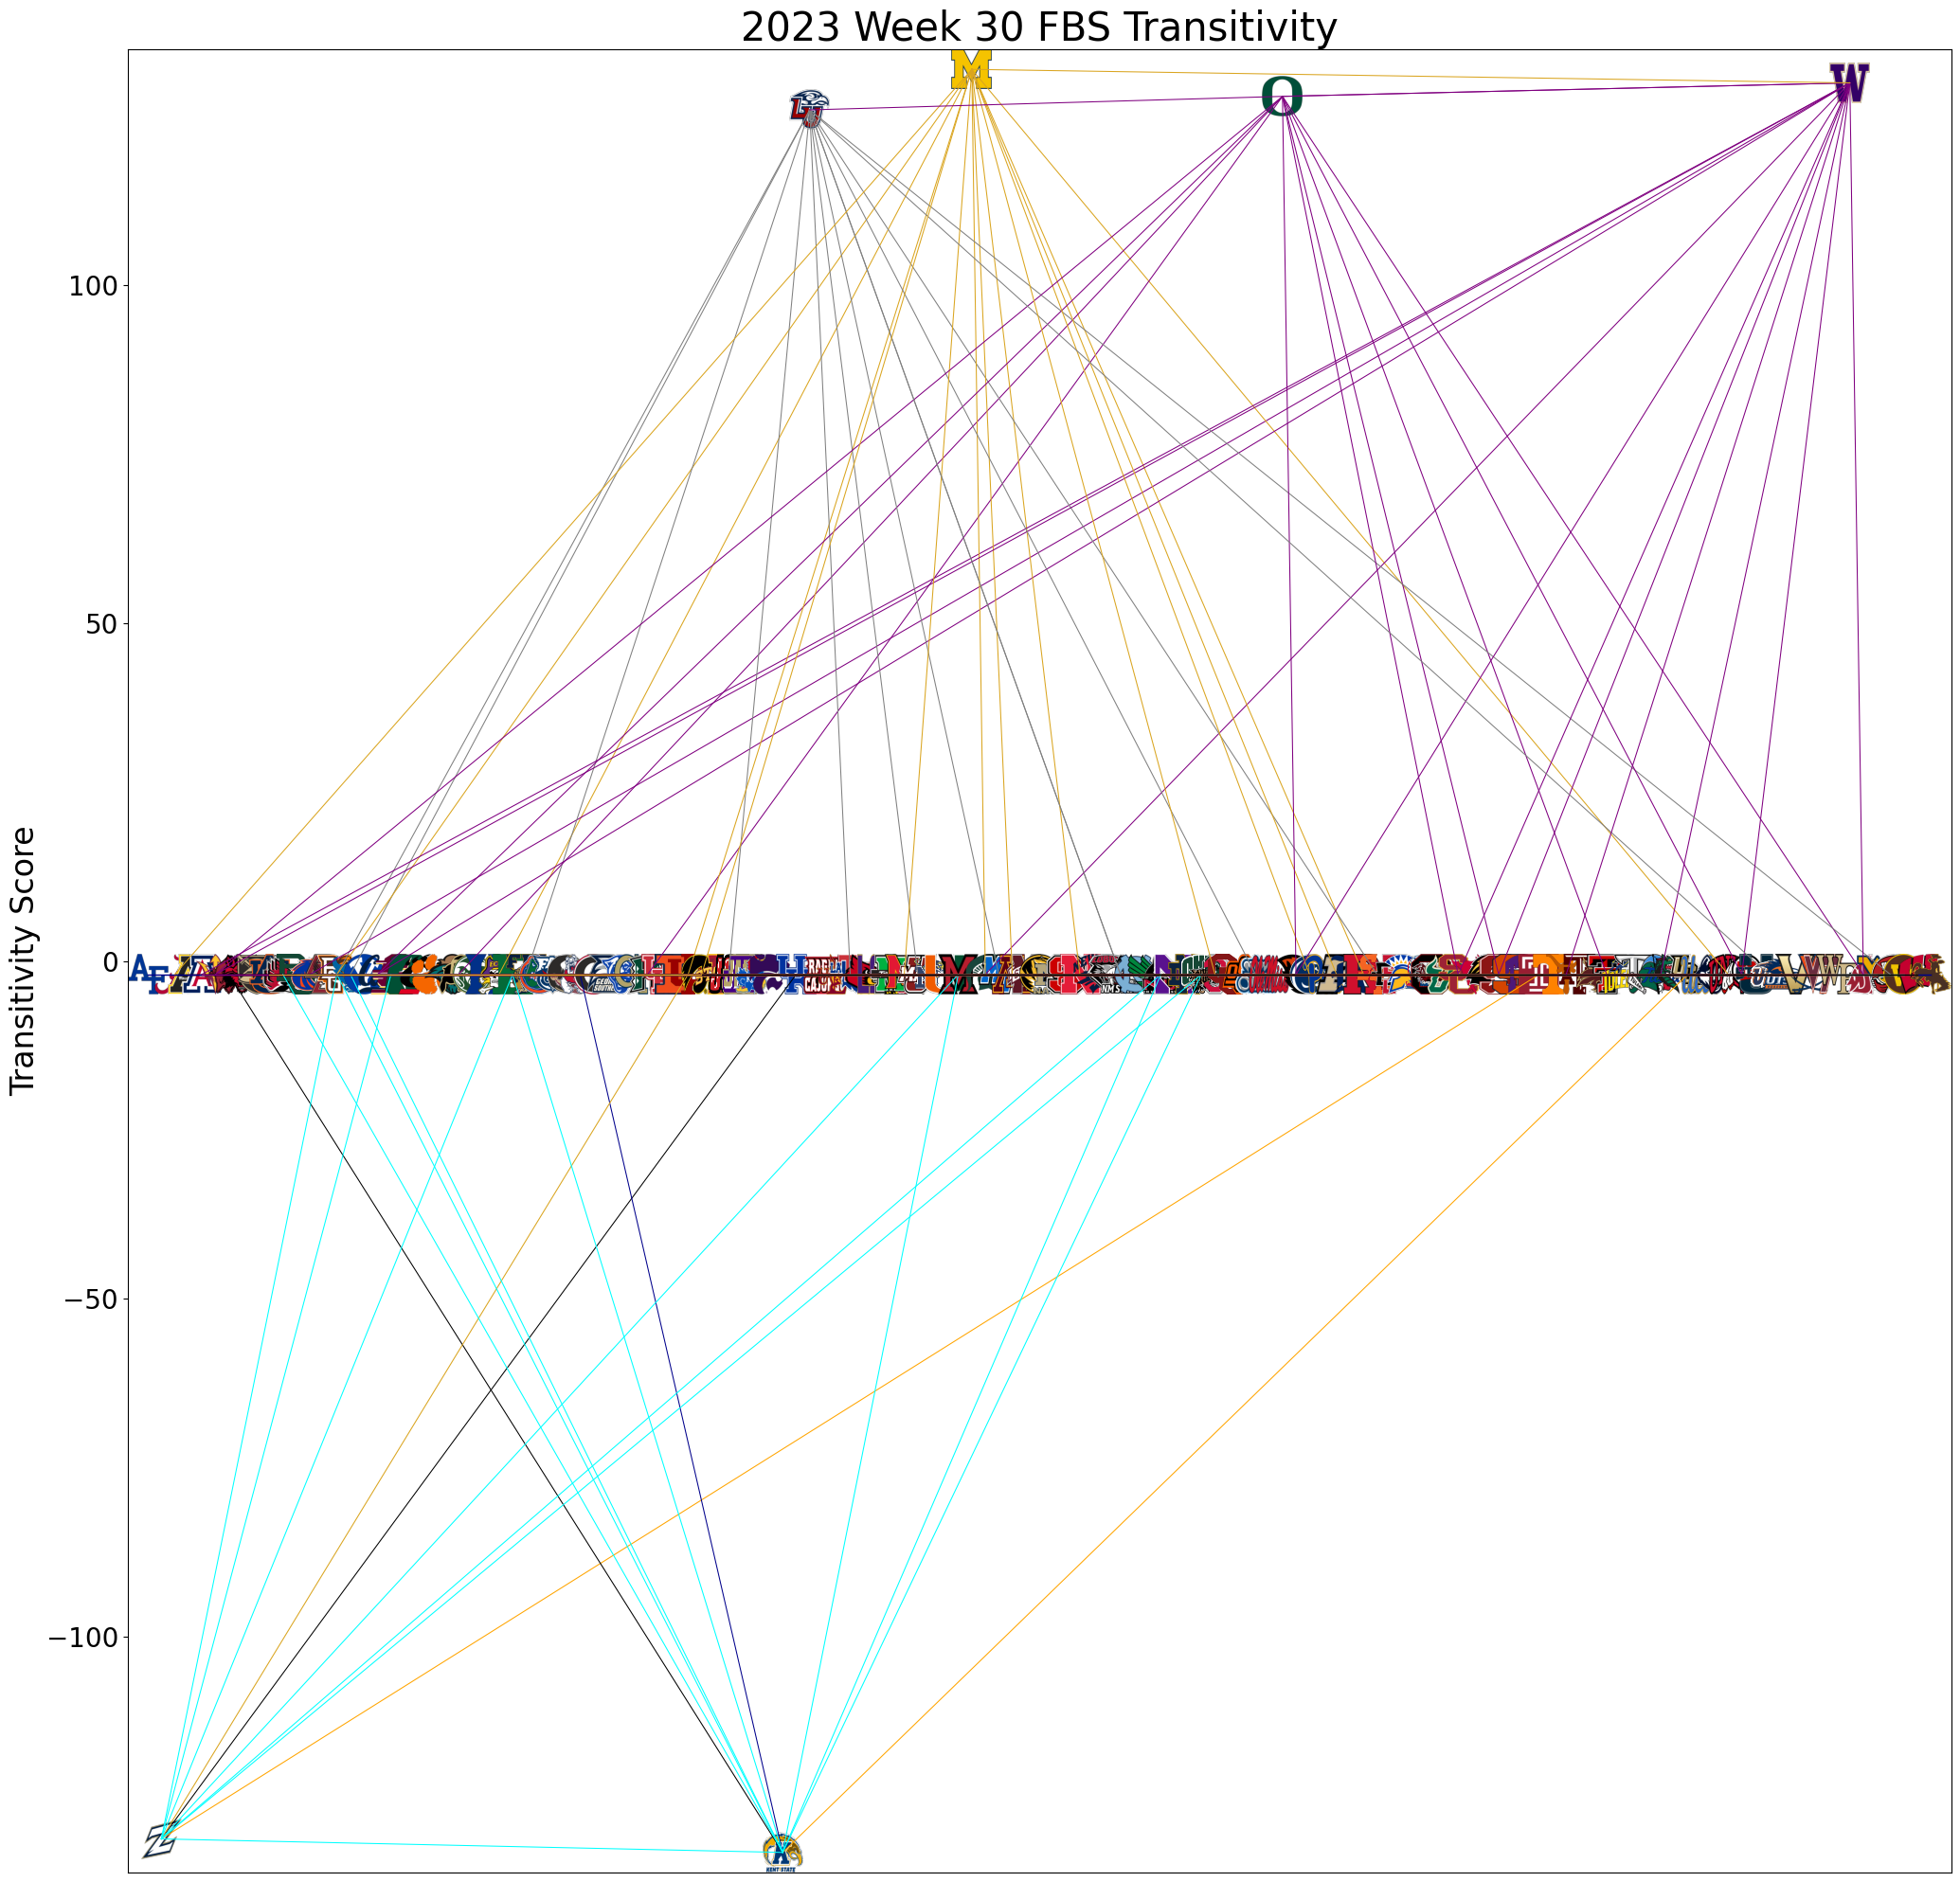

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator
from google.colab import files

Teams = FBS # gets list of teams
figure(figsize=(25, 25)) # sets size of plot
ax = plt.gca() # sets up pyplot
ax.get_xaxis().set_visible(False) # turns off axes
# empty sets for X and Y
Y = []
X = []
ymax = max(df_team_scores_raw["Transitivity Score"]) # find highest transitivity score
ymin = min(df_team_scores_raw["Transitivity Score"]) # find lowest transitivity score
separation = 4 # determines x distance between images in plot
logosize = 6 # sets size of images in plot
i = 0 # set iteration counter at 0
xmin = 0 # sets x start at 0
xmax = len(Teams)*separation # sets x max per number of teams
ratio2 = abs((xmax-xmin)/(ymin-ymax))
for team in Teams:
    l = list(df_team_scores_raw["Team"])
    ymax = max(df_team_scores_raw["Transitivity Score"])
    ymin = min(df_team_scores_raw["Transitivity Score"])
    index = l.index(team)
    TS = df_team_scores_raw.iloc[index,4] # pulls transitive data from dataframe
    X.append(i) #
    Y.append(TS)
    team_format = team.replace(" ", "_") # updates team name to convention for file for team logo
    img = mpimg.imread(("/content/drive/MyDrive/College Logos/{}_logo.png").format(team_format)) # finds team logo from drive
    imgplot = plt.imshow(img,extent=[i-logosize,i+logosize,(TS-(logosize/ratio2)),(TS+(logosize/ratio2))])
    i = i+separation # iterates for separating logos on x axis
Xdict = dict(zip(Teams, X)) # creates dictionary for teams and x coordinate
Ydict = dict(zip(Teams, Y)) # creates dictionary for teams and y coordinate
ymax = max(Y)+(logosize/ratio2)
ymin = min(Y)-(logosize/ratio2)
ax.set_xlim(xmin-logosize,xmax+logosize-separation)
ax.set_ylim(ymin,ymax)
ax.set_aspect(1)

# this loop creates lines to signify teams that beat other teams
for winner, loser in zip(df_Games['Winner'],df_Games['Loser']):
    if winner in FBS and loser in FBS:
        x1 = Xdict[winner] # sets first x coordinate of winner
        x2 = Xdict[loser] # sets second x coordinate of loser
        y1 = Ydict[winner] # sets first y coordinate of winner
        y2 = Ydict[loser] # sets second y coordinate of loser
        x_values = [x1,x2] # lists x values
        y_values = [y1,y2] # lists y values
        a,c = get_Conference(winner) # finds conference of winner, determines line color
        plt.plot(x_values, y_values, color = c, linestyle = '-', linewidth = .75) # plots lines
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ratio2 = abs((x_right-x_left)/(y_low-y_high))
#plt.grid(axis='y',linestyle='--')
title = ('{} Week {} FBS Transitivity').format(year,week) # gives title for plot
plt.title(title, fontsize=30) # assigns title an font size
plt.ylabel('Transitivity Score', fontsize=24) # assigns y label and font size
plt.yticks(fontsize=20) # assigns font size to y labels
fig1 = plt.gcf() # assigns plot to figure 1
plt.show() # displays plot in side window
title2 = title+".png" # gives title for file
fig1.savefig(title2) # saves figure
files.download(title2) # automatically downloads figure to computer


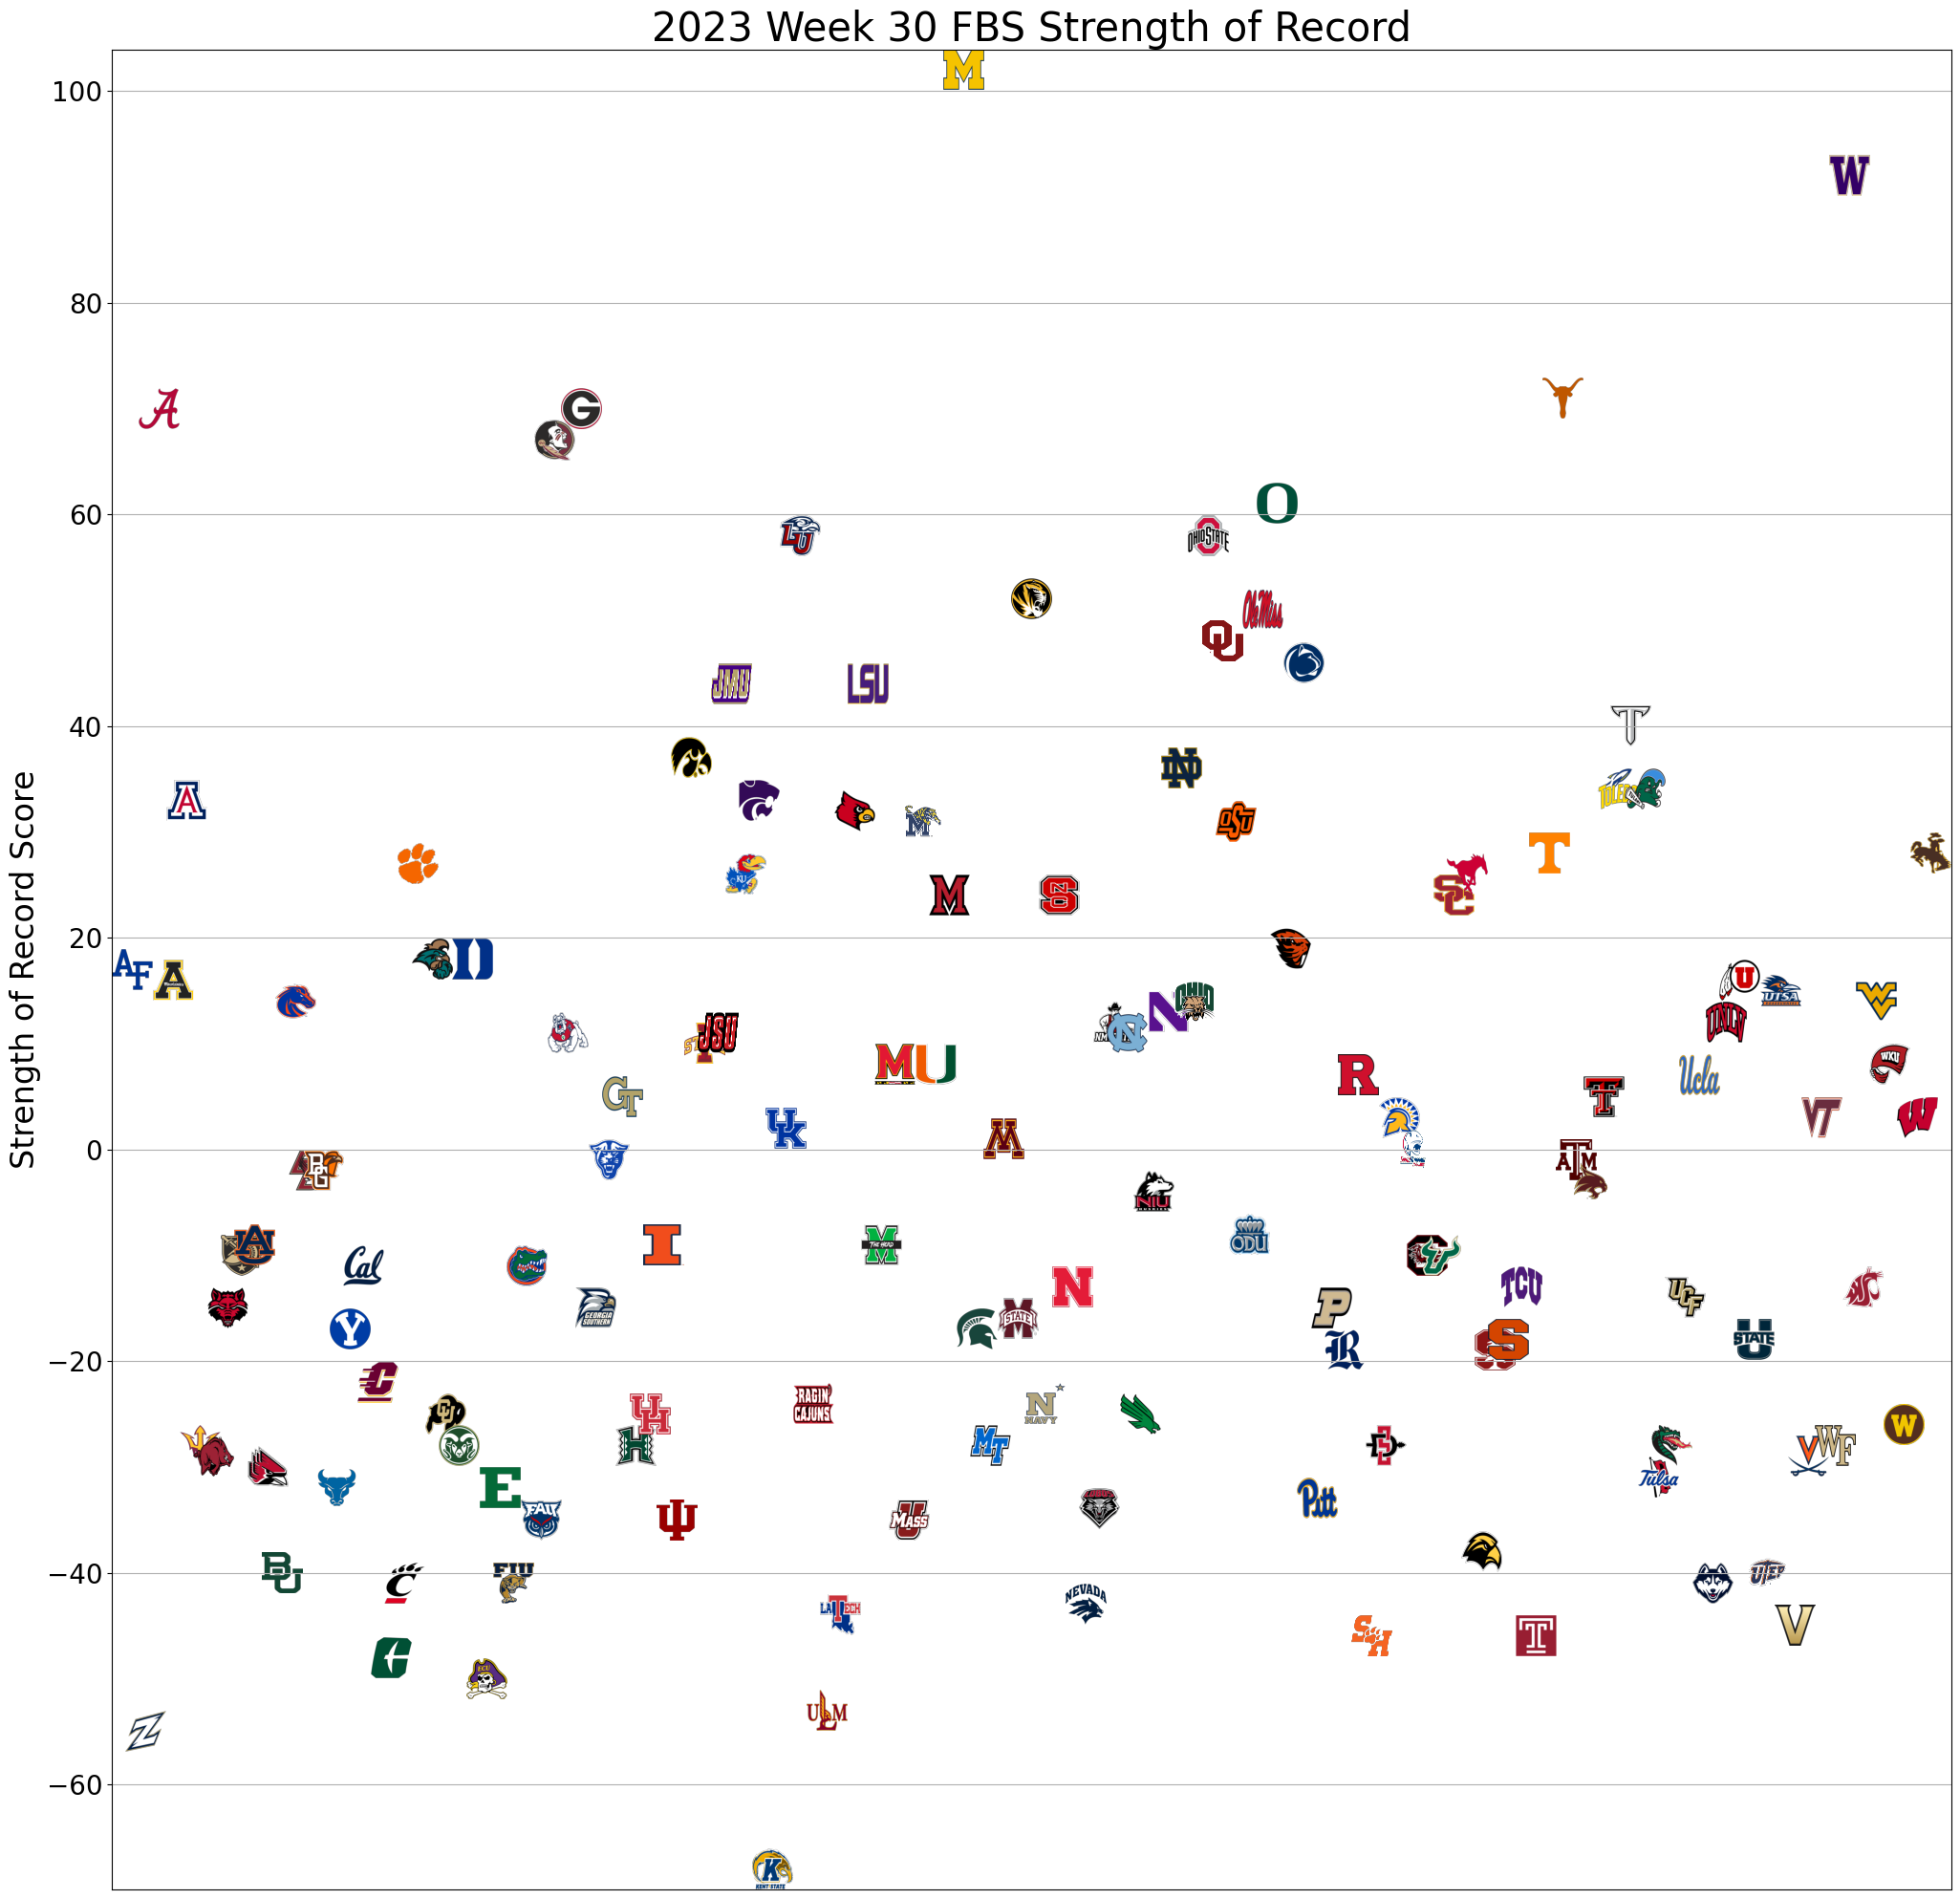

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Teams = FBS
figure(figsize=(25, 25))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
Y2 = []
y2max = max(df_team_scores_raw["Strength of Record"])
y2min = min(df_team_scores_raw["Strength of Record"])
separation = 4
logosize = 6
i = 0
xmin = 0
xmax = len(Teams)*separation
ratio2 = abs((xmax-xmin)/(y2min-y2max))
for team in Teams:
    l = list(df_team_scores_raw["Team"])
    y2max = max(df_team_scores_raw["Strength of Record"])
    y2min = min(df_team_scores_raw["Strength of Record"])
    index = l.index(team)
    SOR = df_team_scores_raw.iloc[index,7]
    X.append(i)
    Y2.append(SOR)
    team_format = team.replace(" ", "_")
    img = mpimg.imread(("/content/drive/MyDrive/College Logos/{}_logo.png").format(team_format))
    imgplot = plt.imshow(img,extent=[i-logosize,i+logosize,(SOR-(logosize/ratio2)),(SOR+(logosize/ratio2))])
    i = i+separation
X2dict = dict(zip(Teams, X))
Y2dict = dict(zip(Teams, Y2))
y2max = max(Y2)+(logosize/ratio2)
y2min = min(Y2)-(logosize/ratio2)
ax.set_xlim(xmin-logosize,xmax+logosize-separation)
ax.set_ylim(y2min,y2max)
ax.set_aspect(1)
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ratio2 = abs((x_right-x_left)/(y_low-y_high))
plt.grid(axis='y')
title = ('{} Week {} FBS Strength of Record').format(year,week)
plt.title(title, fontsize=30)
plt.ylabel('Strength of Record Score', fontsize=24)
plt.yticks(fontsize=20)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
fig2 = plt.gcf()
plt.show()
title2 = title+".png"
fig2.savefig(title2)
files.download(title2)

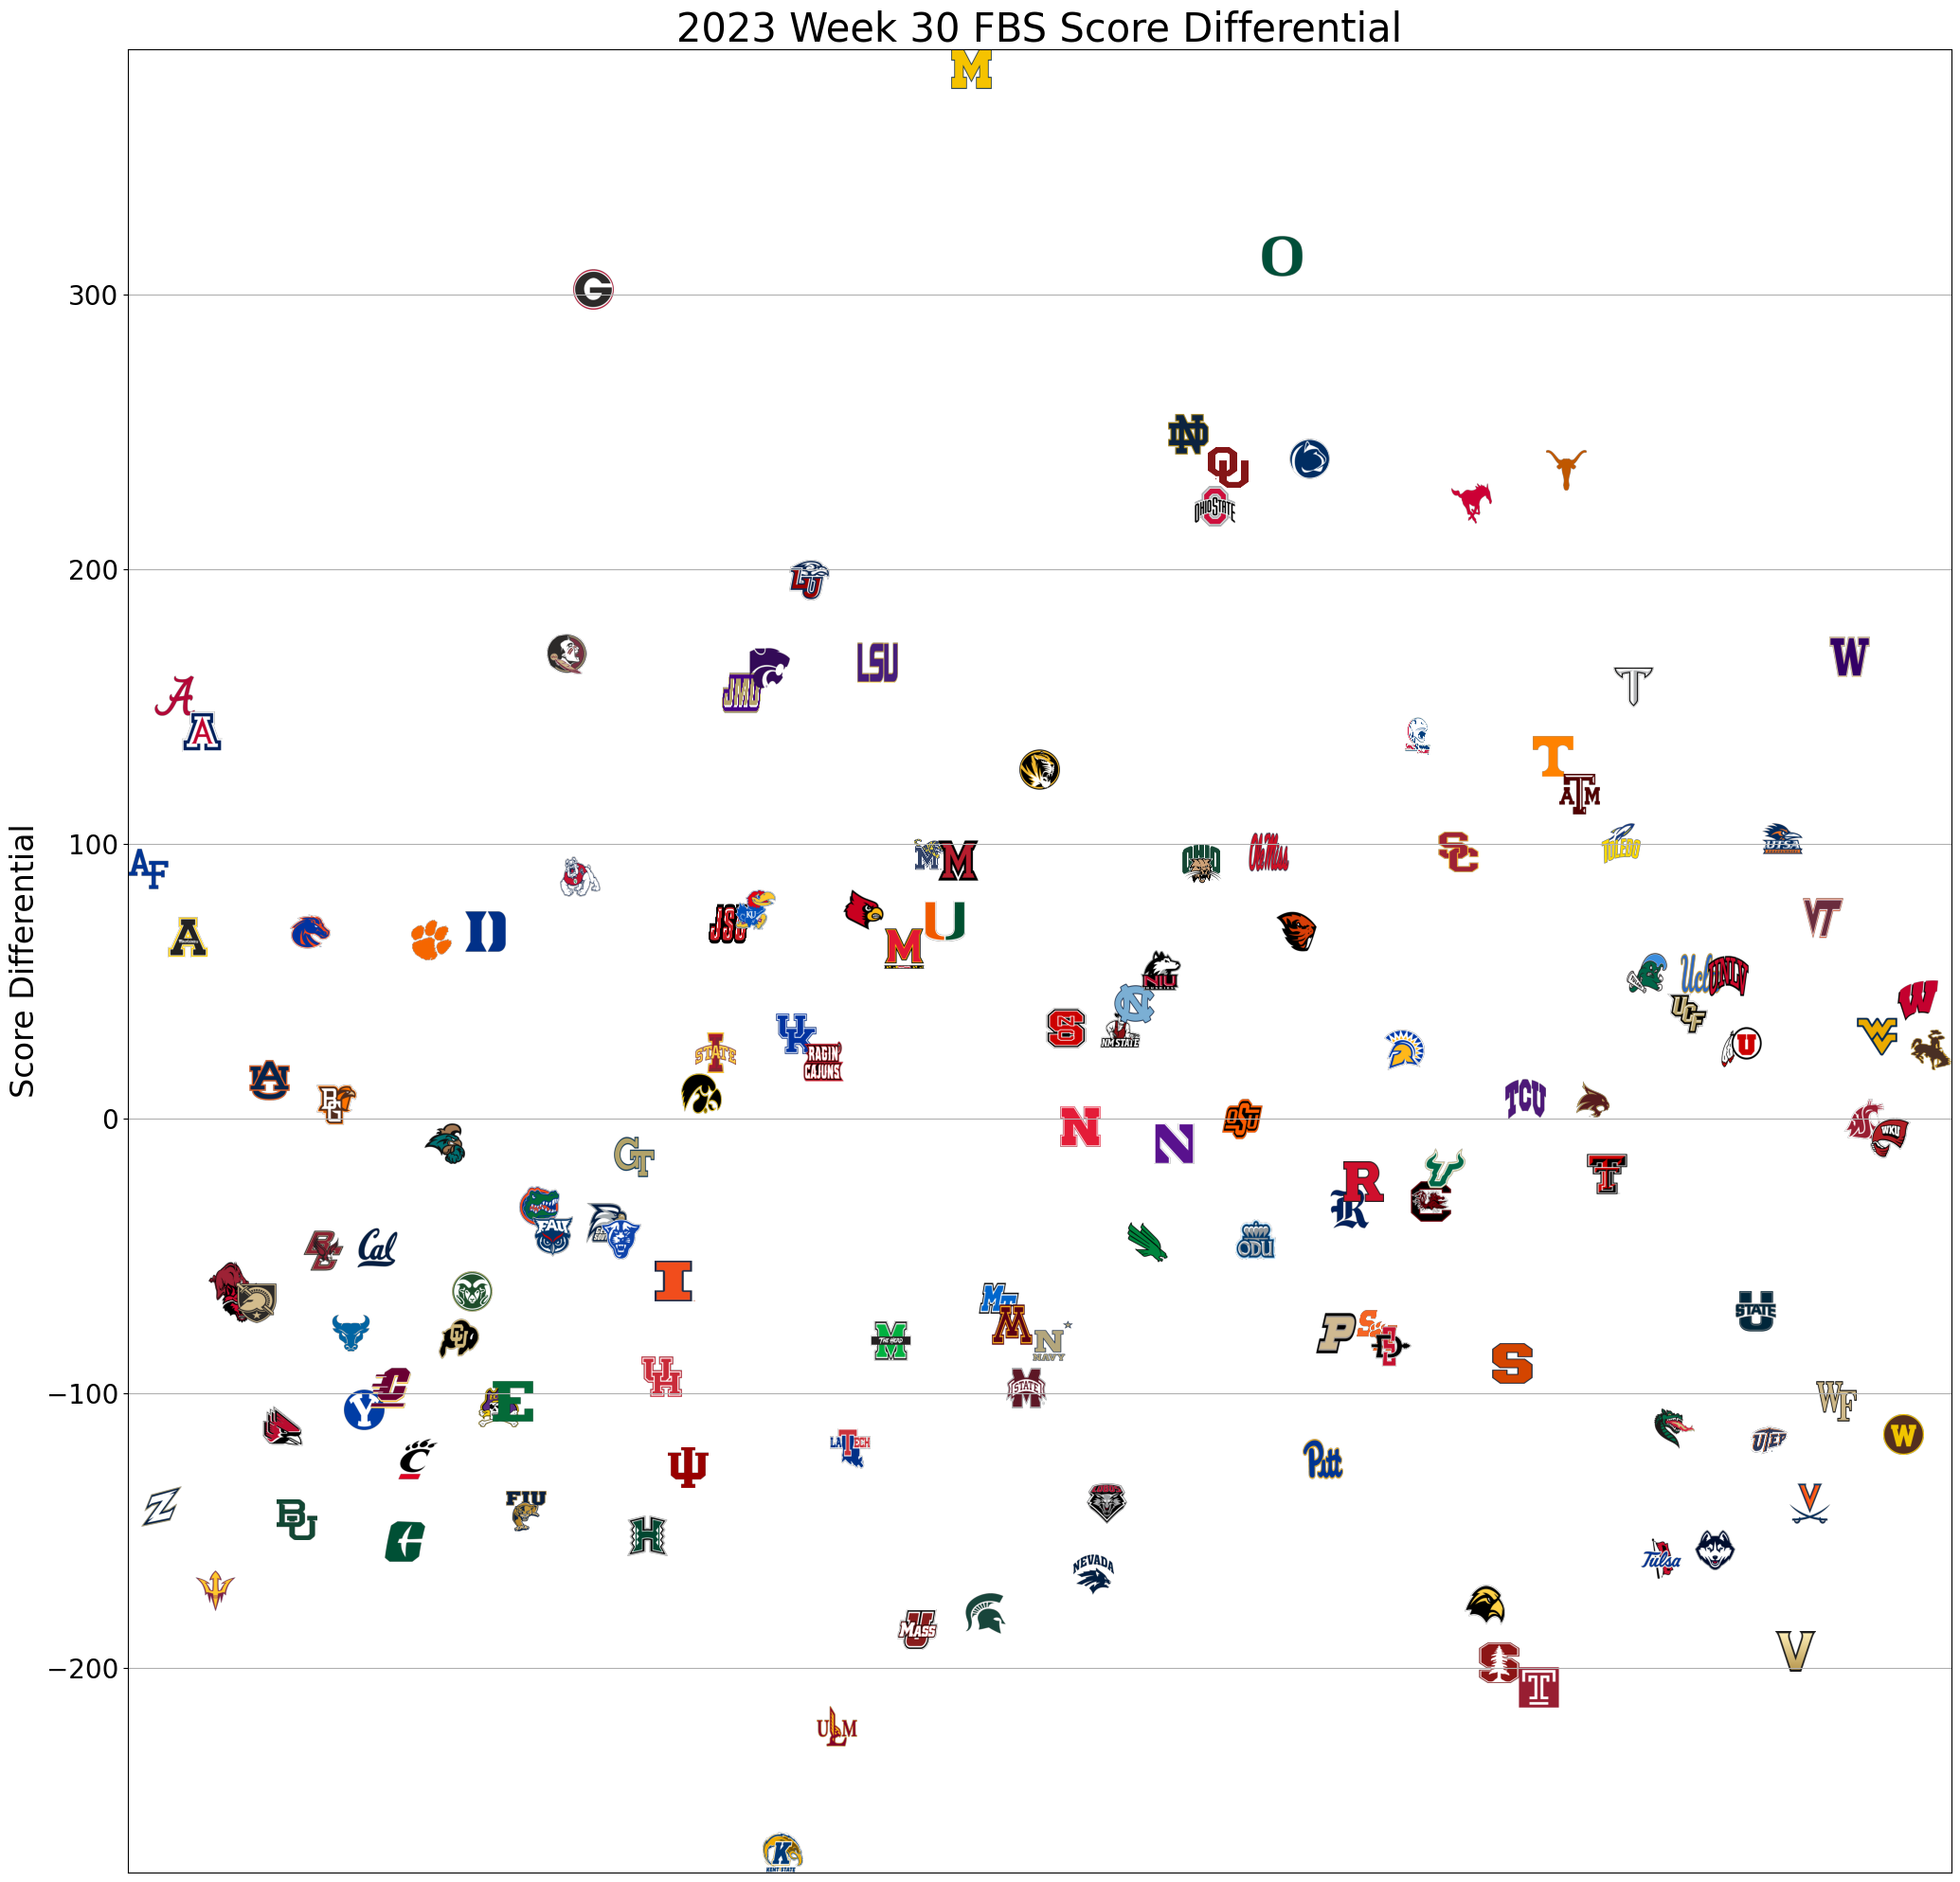

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Teams = FBS
figure(figsize=(25, 25))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
Y3 = []
y3max = max(df_team_scores_raw["Total Point Differential"])
y3min = min(df_team_scores_raw["Total Point Differential"])
separation = 4
logosize = 6
i = 0
xmin = 0
xmax = len(Teams)*separation
ratio2 = abs((xmax-xmin)/(y3min-y3max))
for team in Teams:
    l = list(df_team_scores_raw["Team"])
    y3max = max(df_team_scores_raw["Total Point Differential"])
    y3min = min(df_team_scores_raw["Total Point Differential"])
    index = l.index(team)
    PD = df_team_scores_raw.iloc[index,11]
    X.append(i)
    Y3.append(PD)
    team_format = team.replace(" ", "_")
    img = mpimg.imread(("/content/drive/MyDrive/College Logos/{}_logo.png").format(team_format))
    imgplot = plt.imshow(img,extent=[i-logosize,i+logosize,(PD-(logosize/ratio2)),(PD+(logosize/ratio2))])
    i = i+separation
X3dict = dict(zip(Teams, X))
Y3dict = dict(zip(Teams, Y3))
y3max = max(Y3)+(logosize/ratio2)
y3min = min(Y3)-(logosize/ratio2)
ax.set_xlim(xmin-logosize,xmax+logosize-separation)
ax.set_ylim(y3min,y3max)
ax.set_aspect(1)
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ratio2 = abs((x_right-x_left)/(y_low-y_high))
plt.grid(axis='y')
title = ('{} Week {} FBS Score Differential').format(year,week)
plt.title(title, fontsize=30)
plt.ylabel('Score Differential', fontsize=24)
plt.yticks(fontsize=20)
fig3 = plt.gcf()
plt.show()
title2 = title+".png"
fig3.savefig(title2)
files.download(title2)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
Team = "Ohio State"
Teams = [Team]
Twins = get_T_wins(Team,df_Games)
Tlosses = get_T_losses(Team,df_Games)
Teams = Teams + Twins
for t in Tlosses:
   if t not in Twins:
      Teams.append(t)
Teams = sorted(Teams)
figure(figsize=(25, 25))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
Y = []
X = []
ymax = max(df_team_scores_raw["Transitivity Score"])
ymin = min(df_team_scores_raw["Transitivity Score"])
separation = 4
logosize = 6
i = 0
#xmin = 0
#xmax = len(Teams)*separation
ratio2 = abs((xmax-xmin)/(ymin-ymax))
for team in Teams:
#    l = list(df_team_scores_raw["Team"])
#    index = l.index(team)
#    TS = df_team_scores_raw.iloc[index,4]
#    X.append(i)
#    Y.append(TS)
    team_format = team.replace(" ", "_")
    x = Xdict[team]
    y = Ydict[team]
    img = mpimg.imread(("/content/drive/MyDrive/College Logos/{}_logo.png").format(team_format))
    imgplot = plt.imshow(img,extent=[x-logosize,x+logosize,(y-(logosize/ratio2)),(y+(logosize/ratio2))])
#    i = i+separation
#Xdict = dict(zip(Teams, X))
#Ydict = dict(zip(Teams, Y))
#ymax = max(Y)
#ymin = min(Y)
ymax = ymax+(logosize/ratio2)
ymin = ymin-(logosize/ratio2)
ax.set_xlim(xmin-logosize,xmax+logosize-separation)
ax.set_ylim(ymin,ymax)
ax.set_aspect(1)

for winner, loser in zip(df_Games['Winner'],df_Games['Loser']):
    if winner in Teams and loser in Teams:
        x1 = Xdict[winner]
        x2 = Xdict[loser]
        y1 = Ydict[winner]
        y2 = Ydict[loser]
        x_values = [x1,x2]
        y_values = [y1,y2]
        a,c = get_Conference(winner)
        plt.plot(x_values, y_values, color = c, linestyle = '-', linewidth = .75)
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ratio2 = abs((x_right-x_left)/(y_low-y_high))
plt.ylabel("Transitivity Score")
yticksmin = 10*round(ymin/10)
yticksmax = 10*round(ymax/10)
#plt.yticks(np.arange(yticksmin, yticksmax, step=10))
title = ('{} Week {} FBS Transitivity - {}').format(year,week,Team)
plt.title(title, fontsize=30)
plt.ylabel('Transitivity Score', fontsize=24)
plt.yticks(fontsize=20)
fig4 = plt.gcf()
plt.show()
savename = (title+".png")
fig4.savefig(savename)
files.download(savename)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
Team = "Auburn"
Teams = [Team]
Twins = get_T_wins(Team,df_Games)
Tlosses = get_T_losses(Team,df_Games)
Teams = Teams + Twins
for t in Tlosses:
   if t not in Twins:
      Teams.append(t)
Teams = sorted(Teams)
figure(figsize=(25, 25))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
Y = []
X = []
ymax = max(df_team_scores_raw["Transitivity Score"])
ymin = min(df_team_scores_raw["Transitivity Score"])
separation = 4
logosize = 6
i = 0
xmin = 0
xmax = len(Teams)*separation
ratio2 = abs((xmax-xmin)/(ymin-ymax))
for team in Teams:
    l = list(df_team_scores_raw["Team"])
    index = l.index(team)
    TS = df_team_scores_raw.iloc[index,4]
    X.append(i)
    Y.append(TS)
    team_format = team.replace(" ", "_")
    img = mpimg.imread(("/content/drive/MyDrive/College Logos/{}_logo.png").format(team_format))
    imgplot = plt.imshow(img,extent=[i-logosize,i+logosize,(TS-(logosize/ratio2)),(TS+(logosize/ratio2))])
    i = i+separation
Xdict = dict(zip(Teams, X))
Ydict = dict(zip(Teams, Y))
ymax = max(Y)
ymin = min(Y)
ymax = ymax+(logosize/ratio2)
ymin = ymin-(logosize/ratio2)
ax.set_xlim(xmin-logosize,xmax+logosize-separation)
ax.set_ylim(ymin,ymax)
ax.set_aspect(1)

for winner, loser in zip(df_Games['Winner'],df_Games['Loser']):
    if winner in Teams and loser in Teams:
        x1 = Xdict[winner]
        x2 = Xdict[loser]
        y1 = Ydict[winner]
        y2 = Ydict[loser]
        x_values = [x1,x2]
        y_values = [y1,y2]
        a,c = get_Conference(winner)
        plt.plot(x_values, y_values, color = c, linestyle = '-', linewidth = .75)
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ratio2 = abs((x_right-x_left)/(y_low-y_high))
plt.ylabel("Transitivity Score")
yticksmin = 10*round(ymin/10)
yticksmax = 10*round(ymax/10)
#plt.yticks(np.arange(yticksmin, yticksmax, step=10))
title = ('2022 Week 6 FBS Transitivity - {}').format(Team)
plt.title(title, fontsize=24)
plt.ylabel('Transitivity Score', fontsize=18)
plt.yticks(fontsize=16)
fig6 = plt.gcf()
plt.show()
savename = ("2022 Week 6 FBS Transitivity - {}.png").format(Team)
fig6.savefig(savename)
files.download(savename)

# Troubleshooting

In [ ]:
get_Teams(2023)

['Air Force',
 'Akron',
 'Alabama',
 'Appalachian State',
 'Arizona',
 'Arizona State',
 'Arkansas',
 'Arkansas State',
 'Army',
 'Auburn',
 'Ball State',
 'Baylor',
 'Boise State',
 'Boston College',
 'Bowling Green',
 'Buffalo',
 'BYU',
 'California',
 'Central Michigan',
 'Charlotte',
 'Cincinnati',
 'Clemson',
 'Coastal Carolina',
 'Colorado',
 'Colorado State',
 'Duke',
 'East Carolina',
 'Eastern Michigan',
 'FIU',
 'Florida',
 'Florida Atlantic',
 'Florida State',
 'Fresno State',
 'Georgia',
 'Georgia Southern',
 'Georgia State',
 'Georgia Tech',
 'Hawaii',
 'Houston',
 'Illinois',
 'Indiana',
 'Iowa',
 'Iowa State',
 'Jacksonville State',
 'James Madison',
 'Kansas',
 'Kansas State',
 'Kent State',
 'Kentucky',
 'Liberty',
 'Louisiana',
 'Louisiana–Monroe',
 'Louisiana Tech',
 'Louisville',
 'LSU',
 'Marshall',
 'Maryland',
 'Massachusetts',
 'Memphis',
 'Miami (FL)',
 'Miami (OH)',
 'Michigan',
 'Michigan State',
 'Middle Tennessee',
 'Minnesota',
 'Mississippi State',
 'Miss

In [ ]:
Teams = get_Teams(2024)
print(len(Teams))
Teams


134


['Air Force',
 'Akron',
 'Alabama',
 'Appalachian State',
 'Arizona',
 'Arizona State',
 'Arkansas',
 'Arkansas State',
 'Army',
 'Auburn',
 'Ball State',
 'Baylor',
 'Boise State',
 'Boston College',
 'Bowling Green',
 'Buffalo',
 'BYU',
 'California',
 'Central Michigan',
 'Charlotte',
 'Cincinnati',
 'Clemson',
 'Coastal Carolina',
 'Colorado',
 'Colorado State',
 'Duke',
 'East Carolina',
 'Eastern Michigan',
 'FIU',
 'Florida',
 'Florida Atlantic',
 'Florida State',
 'Fresno State',
 'Georgia',
 'Georgia Southern',
 'Georgia State',
 'Georgia Tech',
 'Hawaii',
 'Houston',
 'Illinois',
 'Indiana',
 'Iowa',
 'Iowa State',
 'Jacksonville State',
 'James Madison',
 'Kansas',
 'Kansas State',
 'Kennesaw State',
 'Kent State',
 'Kentucky',
 'Liberty',
 'Louisiana',
 'Louisiana–Monroe',
 'Louisiana Tech',
 'Louisville',
 'LSU',
 'Marshall',
 'Maryland',
 'Massachusetts',
 'Memphis',
 'Miami (FL)',
 'Miami (OH)',
 'Michigan',
 'Michigan State',
 'Middle Tennessee',
 'Minnesota',
 'Mississ